This is for plotting velocity variance under neutral condition

Note: 1. data with diag_csat_ins >= 65 are discarded in advance.

2. B1 (the 4th level) uses different CSAT model.

2022-6-15

In [2]:
# This jupyter notebook command inserts matplotlib graphics in 
# to the workbook
%matplotlib inline

# import packages
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import pickle
import time
from matplotlib.pyplot import figure
import scipy.io as sio
from datetime import date, timedelta
from math import *
from scipy.stats import gmean
from scipy import ndimage
from scipy import stats
from statistics import mode

# directories
IN_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/basic_processed_data/"
IN_DIRECTORY2 = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/processed_data/"
msk_DIR = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/mask_data/"
OUT_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/neutral_data_20200925_20210423/"
PLOT_DIRECTORY = "/projectnb/urbanclimate/yueqin/idaho_ec_jupyter/fig_neutral/"
ins_var=['u_ins'] # 36000 instantaneous variables per hour 
tur_var=['u_tur','v_tur','w_tur'] # 36000 instantaneous variables per hour 
avg_var=['u_avg','u_star','L_H2','v_avg','u_std','v_std','w_std','T_avg','rot_ang_v'] # 1 averaged variable per hour
flg_var=['diag_csat_ins','sig_irga_ins']
msk = ['mask_INL_all_1d']
neutral_var = ['neutral_case','u_star_mean','temp_stability','kappa_m2',
             'kappa_m2_stability_corrected','u_star_dev','u_star_m1_sel_dev',
             'u_star_m1_dev','u_star_m1_sel','u_star_m1','u_star_fit','u_star_m2',
             'zo_m1','zo_m1_sel','u_avg_neutral','v_avg_neutral','w_avg_neutral',
             'u_star_m1_dev_abs_mean','u_star_m1_sel_dev_abs_mean','u_star_m2_dev_abs_mean',
             'u_std_neutral','v_std_neutral','w_std_neutral',
             'ist_before','r2_m1','r2_m1_sel','r2_m2',
             'u_star_m2_dif','wind_ang_neutral','wind_diff_max_neutral','u_star_neutral',
              'kappa_m2_ec_mean','u_star_dif_mean','wdir_neutral']
out_var=['delta0','z_delta0','A1_fit','r2_A1_fit','A1_ec_mean','r2_A1_ec_mean',
         'A1_m1','r2_A1_m1','re_delta','re_z','uw_neutral']

## Define constants and labels ##

In [3]:
sonum    =12                       # number of sonic
z        = np.array([1.2,2,3.5,6,8.2,12.8,
                     15.8,23,30.3,40.2,50.6,60.5])  # height of sonic above ground, m
frequency=10                   # sampling frequency, Hz
time_avg =3600                  # average time, s
rpat = time_avg*frequency           # number of lines for a loop

# physical constants (or values that are assumed constant)
Rw  = 461.5     # ideal gas constant for water vapor, J/kg*K
Rd  = 287.05    # ideal gas constant for dry air, J/kg*K
Lv  = 1000*2257 # latent heat of vaporization (water), J/kg
Cp  = 1005      # approximate constant pressure specific heat of air, J/kg*K
kappa   = 0.4       # Von Karman constant
g   = 9.81      # acceleration of gravity, m/s^2
nu = 1.48 * 10**(-5) # kinematic viscosity, m2 /s

A1 = 1 # constants in Townsend's formulations for the normalized standard deviation of horizontal velocity
B1 = 2.5

# selected levels
# list_sel = range(5,11) # from level 6 to level 11
list_sel_m1 = np.array([5,6,7,8,9,10]) # from level 6 to level 11
list_sel_m2 = np.array([5,6,7,8,9,10])
list_sel_delta = np.array([7,8,9,10]) # from level 8 to level 11
# list_all = np.array([0,1,2,3,6,7,8,9,10,11])
list_col = ['C1','C2','C3','C4','B1','B2','B3','B4','A1','A2','A3','A4']
xtick_labels = ["1.2","2","3.5","6","8.2","12.8","15.8","23","30.3","40.2","50.6","60.5"]

load_tur = True

## Define functions ##

In [4]:
def date_list(sdate,edate):
    """method used for creating date list"""
    delta = edate - sdate       # as timedelta
    day = [sdate+timedelta(days=x) for x in range(delta.days+1)]
    return day

def Gauss(N, sigma):
    x = np.linspace(1,N,N)- N/2
    Gaussian_filtered = np.exp(-(x**2)/(2*sigma**2))/(sigma*sqrt(2*pi))
    Gaussian_filtered = Gaussian_filtered/np.nansum(Gaussian_filtered) # normalize
    return Gaussian_filtered
    
def BOX(N, size):
    x = np.linspace(1,N,N).T- N/2
    BOX_filtered = np.zeros([N,1])
    msk = abs(x)<(size/2)
    BOX_filtered[msk] = 1
    # for i in range(N):
    #     if (x[i]>size/2) or (x[i]<-size/2):
    #         BOX_filtered[i] = 0
    #     else:
    #         BOX_filtered[i] = 1
    BOX_filtered = BOX_filtered/np.nansum(BOX_filtered)  # normalize
    return BOX_filtered

def conv_circ( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
    '''
    return np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(ker) ))

def filter_fixed_delta(u_tur,v_tur,w_tur,u_avg,frequency,select_for_fit_variance,
                       init_delta_value,do_plot):
    u_tur_save = u_tur
    x_temp = np.nanmean(u_tur[:,select_for_fit_variance], axis=1)
    y_temp = np.nanmean(v_tur[:,select_for_fit_variance], axis=1)
    z_temp = np.nanmean(w_tur[:,select_for_fit_variance], axis=1)
    filter_frequency = init_delta_value 
    filter_size = np.round(filter_frequency/frequency) # the number of points to be averaged
    gaussFilter = Gauss(len(x_temp),(1/12*filter_size**2)**0.5)
    # print(filter_size)
    #! filter_size is the number of points to be averaged in order to go from 'frequency' to 'filter_frequency'
    #! the reason 'sigma^2 = 1/12 filter_size^2' is used is given in
    #! Pope's book
    # boxFilter = BOX(len(x_temp),filter_size)
    # print(len(boxFilter))
    #! filter_size is the number of points to be averaged in order to go from 'frequency' to 'filter_frequency'
    xfilt = conv_circ(x_temp,gaussFilter)
    yfilt = conv_circ(y_temp,gaussFilter)
    zfilt = conv_circ(z_temp,gaussFilter)
    # xfilt = conv_circ(x_temp,boxFilter)
    # yfilt = conv_circ(y_temp,boxFilter)
    # zfilt = conv_circ(z_temp,boxFilter)
    # print(boxFilter[0:100])
    # print(x_temp[0:100])
    # print(xfilt[0:100])
    nan_msk=np.isnan(xfilt)
    if all(nan_msk):
        print('nan value for xfilt')
        return (None,None,None,None,None,None,None)  

    #! for i in range(sonum):
    u_tur=u_tur-xfilt[:,np.newaxis]
    v_tur=v_tur-yfilt[:,np.newaxis]
    w_tur=w_tur-zfilt[:,np.newaxis]
        
    uw=np.nanmean(u_tur*w_tur,axis=0)
    u_std=np.nanstd(u_tur,axis=0)
    v_std=np.nanstd(v_tur,axis=0)
    w_std=np.nanstd(w_tur,axis=0) 
    # print('done!')
    
    return (u_tur,v_tur,w_tur,u_std,v_std,w_std,uw)

def mean_rep(input_var,rep):
    """ function used for calculte the mean of 3d input and expand result to the size of input variable"""
    var_avg = np.repeat(np.nanmean(input_var,axis=0),rep,0)   
    return var_avg

# Load neutral data #

In [5]:
for var in neutral_var:
    a_file = open(OUT_DIRECTORY + var +'.pkl', "rb")
    globals()[var] = pickle.load(a_file)
    a_file.close()

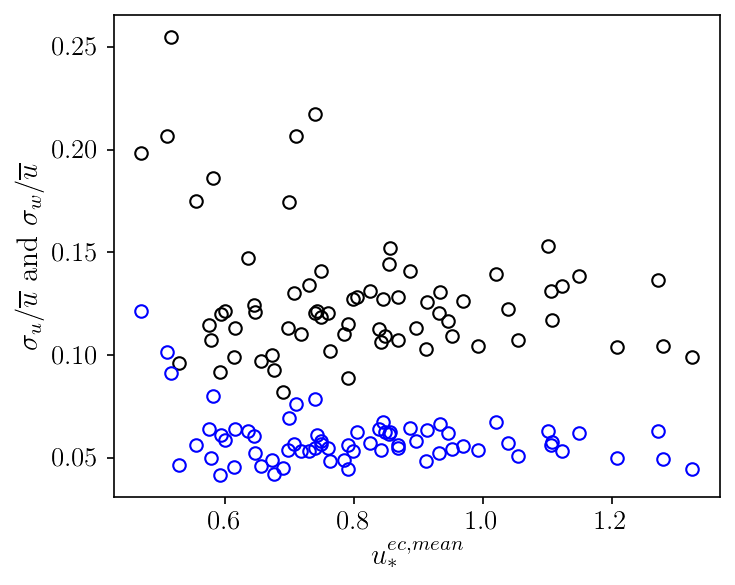

In [19]:
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111) 
plt.plot(u_star_mean,u_std_neutral[:,11]/u_avg_neutral[:,11],'o',color = 'k',markerfacecolor='none')
plt.plot(u_star_mean,w_std_neutral[:,11]/u_avg_neutral[:,11],'o',color = 'blue',markerfacecolor='none')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$\sigma_{u}/\overline{u}$ and $\sigma_{w}/\overline{u}$', fontsize=font_size)

wdir_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
x_temp = np.nanmax(wind_diff_max_neutral, axis=1)
ist = ist_before[:,11]
msk = r2_m2>0.9
msk1 = np.logical_and(msk,ist<0.3)
msk2 = np.logical_and(msk1,r2_m1>0.6)
msk3 = np.logical_and(msk2,x_temp<15)
# plt.plot(u_avg_neutral[~msk3,6],u_std_neutral[~msk3,5]/u_avg_neutral[~msk3,5],'o',color = 'red',markerfacecolor='none')

# plt.savefig(PLOT_DIRECTORY + 'u_star_mean_intensity.jpg', dpi=200)

## Load instantaneous data and process data ##

In [18]:
nn = len(neutral_case)
A1_fit = np.zeros(nn) * np.nan
r2_A1_fit = np.zeros(nn) * np.nan
A1_ec_mean = np.zeros(nn) * np.nan
r2_A1_ec_mean = np.zeros(nn) * np.nan
A1_m1 = np.zeros(nn) * np.nan
r2_A1_m1 = np.zeros(nn) * np.nan
delta0 = np.zeros(nn) * np.nan
z_delta0 = np.zeros((nn,sonum)) * np.nan
re_delta = np.zeros(nn) * np.nan
re_z = np.zeros(nn) * np.nan
uw_neutral = []
for i in range(nn):
    strday = str(neutral_case[i][0].strftime("%Y%m%d"))
    print('start processing:'+ strday+'_'+str(neutral_case[i][1]))
    # if load_tur:
    #     # load tur variables
    #     for var in tur_var:
    #         a_file = open(OUT_DIRECTORY + var +'_' + strday +'_'+str(neutral_case[i][1]) +'.pkl', "rb")
    #         globals()[var] = pickle.load(a_file)    
    #         a_file.close()
    # 1.find delta
    x_vector = np.log(z[list_sel_delta])
    y_vector_fit = u_std_neutral[i,list_sel_delta]**2/(u_star_fit[i]**2)
    y_vector_ec = u_std_neutral[i,list_sel_delta]**2/(u_star_m2[i]**2)
    y_vector_m1 = u_std_neutral[i,list_sel_delta]**2/(u_star_m1[i]**2)
    ## compute delta by least square fit from multiple levels
    b = np.linalg.lstsq(np.ones([len(x_vector),1]),(y_vector_fit + A1*x_vector)[:])
    delta0[i] = exp((b[0][0]-B1)/A1)
    z_delta0[i,:] = z/delta0[i]
    ## compute re#
    re_delta[i] = u_star_fit[i]*delta0[i]/nu
    re_z[i] = u_star_fit[i]*z[-1]/nu
    
    # 2.compute A1 using u_star_fit
    # u_star_fit is calculated by linearly interpolate to the ground level
    res_fit = stats.linregress(-np.log(z[list_sel_delta]), y_vector_fit)
    A1_fit[i] = res_fit.slope
    r2_A1_fit[i] = res_fit.rvalue**2
    
    # 3.compute A1 using u_star_ec_mean
    # u_star_fit is calculated by linearly interpolate to the ground level
    res_ec_mean = stats.linregress(-np.log(z[list_sel_delta]), y_vector_ec)
    A1_ec_mean[i] = res_ec_mean.slope
    r2_A1_ec_mean[i] = res_ec_mean.rvalue**2
    
    # 4.compute A1 using u_star_m1
    res_m1 = stats.linregress(-np.log(z[list_sel_delta]), y_vector_m1)
    A1_m1[i] = res_m1.slope
    r2_A1_m1[i] = res_m1.rvalue**2
    
    # # momentum fluxes
    # uw_neutral0 = mean_rep(u_tur*w_tur,1)
    # uw_neutral = np.append(uw_neutral,uw_neutral0)

# uw_neutral = np.reshape(uw_neutral,(-1,12))

start processing:20200925_16
start processing:20200925_17
start processing:20200925_19
start processing:20201010_16
start processing:20201010_21
start processing:20201012_17
start processing:20201012_18
start processing:20201013_14
start processing:20201013_16
start processing:20201013_18
start processing:20201013_19
start processing:20201016_17
start processing:20201017_17
start processing:20201018_16
start processing:20201019_9
start processing:20201019_17
start processing:20201021_9
start processing:20201021_15
start processing:20201021_16
start processing:20201021_18
start processing:20201022_4
start processing:20201030_16
start processing:20201030_17
start processing:20201115_11
start processing:20201119_11
start processing:20201119_12
start processing:20201119_13
start processing:20201119_14
start processing:20201119_15
start processing:20201119_16
start processing:20201119_17
start processing:20210103_16
start processing:20210123_11
start processing:20210124_5
start processing:2

# Save var data #

In [19]:
for var in out_var:
    a_file = open(OUT_DIRECTORY + var + '.pkl', "wb")
    pickle.dump(eval(var), a_file)
    a_file.close()

# Load var data #

In [6]:
for var in out_var:
    a_file = open(OUT_DIRECTORY + var +'.pkl', "rb")
    globals()[var] = pickle.load(a_file)
    a_file.close()

In [6]:
%whos ndarray list 

Variable                       Type       Data/Info
---------------------------------------------------
A1_ec_mean                     ndarray    71: 71 elems, type `float64`, 568 bytes
A1_fit                         ndarray    71: 71 elems, type `float64`, 568 bytes
A1_m1                          ndarray    71: 71 elems, type `float64`, 568 bytes
avg_var                        list       n=9
delta0                         ndarray    71: 71 elems, type `float64`, 568 bytes
flg_var                        list       n=2
ins_var                        list       n=1
ist_before                     ndarray    71x12: 852 elems, type `float64`, 6816 bytes
kappa_m2                       ndarray    71: 71 elems, type `float64`, 568 bytes
kappa_m2_ec_mean               ndarray    71: 71 elems, type `float64`, 568 bytes
kappa_m2_stability_corrected   ndarray    71: 71 elems, type `float64`, 568 bytes
list_col                       list       n=12
list_sel_delta                 ndarray    4: 4 ele

In [112]:
abs(u_star_m1-u_star_fit)/u_star_fit

array([0.12537687, 0.0883238 , 0.29265147, 0.22947905, 0.24543936,
       0.11371893, 0.21536851, 0.13895181, 0.17767251, 0.28071758,
       0.22382145, 0.10459882, 0.07351838, 0.08989469, 0.0799383 ,
       0.125569  , 0.05905379, 0.22515471, 0.1299321 , 0.06387998,
       0.14158195, 0.1453879 , 0.14587495, 0.00584486, 0.02898454,
       0.1543976 , 0.0703388 , 0.00801927, 0.02055431, 0.06497292,
       0.26134338, 0.25758222, 0.02644296, 0.17092071, 0.69059165,
       0.03259294, 0.49293967, 0.38428806, 0.10917521, 0.21227651,
       0.22173349, 0.08484793, 0.22382027, 0.09503006, 0.07600222,
       0.16164158, 0.06641869, 0.00748846, 0.02693772, 0.08628215,
       0.56552996, 0.10748667, 0.237781  , 0.18014601, 0.10530868,
       0.02136858, 0.09008646, 0.10984864, 0.07477061, 0.18417229,
       0.17318617, 0.26490109, 0.0540376 , 0.06549632, 0.06522209,
       0.03194798, 0.00719214, 0.01055494, 0.01422166, 0.05502932,
       0.14894013])

# Let's start plotting #

In [7]:
## PLOTTING STUFF
## define useful fonts
plt.rc('text', usetex=True)
# plt.rc('font', family='sans-serif')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "bold"
plt.rc('xtick', labelsize=13) 
plt.rc('ytick', labelsize=13)
font_size = 14
do_plot = True

## A1_m1 vs r2 ##

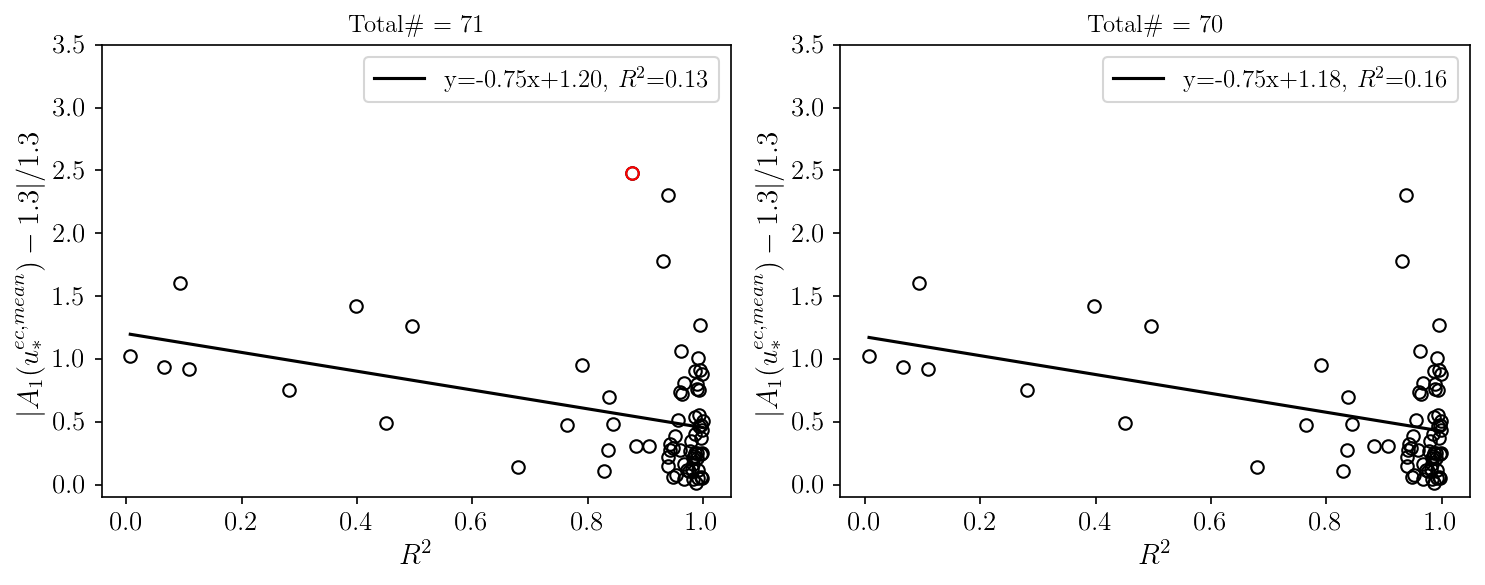

In [17]:
y_temp1 = abs(A1_ec_mean-1.3)/1.3
wdir_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1) # wdir difference between neiboring levels
msk = r2_m2>0

fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121) 
plt.plot(r2_A1_ec_mean[msk],y_temp1[msk],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$R^2$', fontsize=font_size)
plt.ylabel(r'$|A_1(u_*^{ec,mean})-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(r2_A1_ec_mean[msk],y_temp1[msk])
x = np.sort(r2_A1_ec_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:}'.format(len(y_temp1[msk])))
plt.plot(r2_A1_ec_mean[r2_m2<0.85],y_temp1[r2_m2<0.85],'o', color = 'red',markerfacecolor='none')
plt.ylim(-0.1,3.5)

msk1 = r2_m2>0.85
ax3 = fig.add_subplot(122) 
plt.plot(r2_A1_ec_mean[msk1],y_temp1[msk1],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$R^2$', fontsize=font_size)
plt.ylabel(r'$|A_1(u_*^{ec,mean})-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(r2_A1_ec_mean[msk1],y_temp1[msk1])
x = np.sort(r2_A1_ec_mean[msk1])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.title(r'Total\# = {:}'.format(len(y_temp1[msk1])))
plt.legend(fontsize=12)
plt.ylim(-0.1,3.5)
plt.savefig(PLOT_DIRECTORY + 'A1_k_r2.jpg', dpi=200)

## A1 vs ustar ##

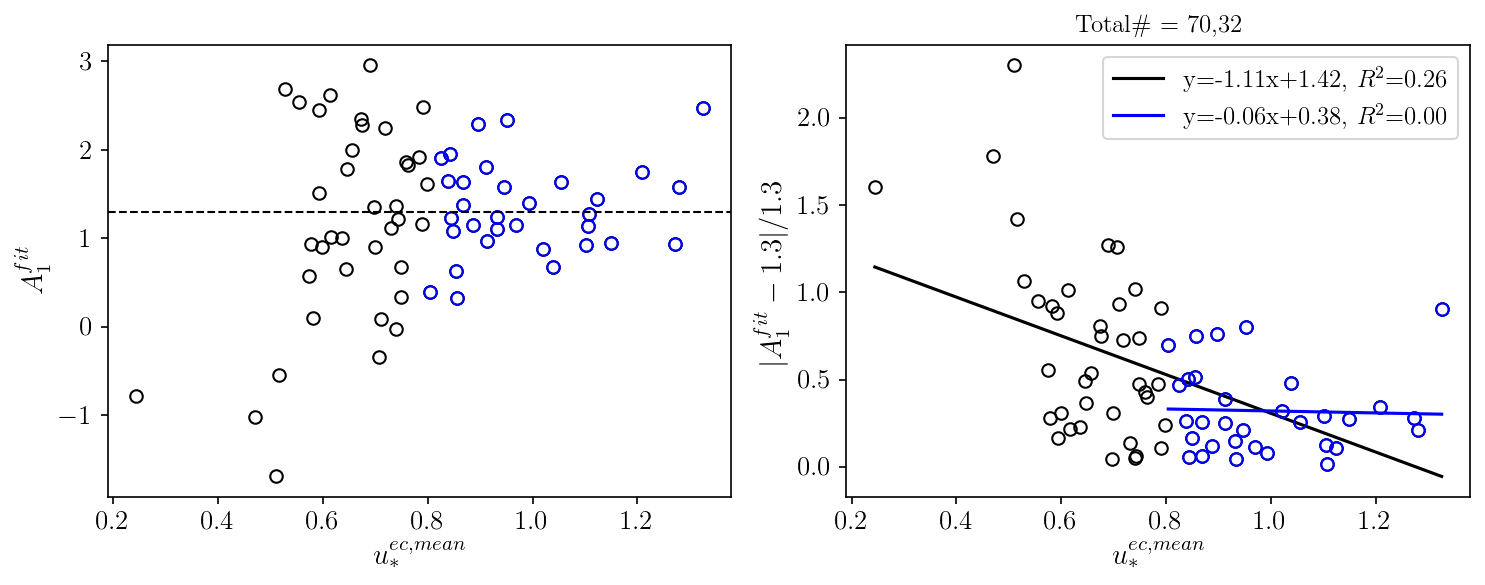

In [24]:
y_temp1 = A1_ec_mean
y_temp = abs(A1_ec_mean-1.3)/1.3
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
wdir_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
msk2 = np.logical_and(msk1,wdir_temp<4)

fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121) 
plt.plot(u_star_mean[msk],y_temp1[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$A_1^{fit}$', fontsize=font_size)
ax1.plot(u_star_mean[msk1],y_temp1[msk1],'o',color = 'blue',markerfacecolor='none')
plt.axhline(y=1.3, color='k', linestyle='--', linewidth=1)

ax2 = fig.add_subplot(122) 
plt.plot(u_star_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk], y_temp[msk])
x = np.sort(u_star_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax2.plot(u_star_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk1],y_temp[msk1])
x = np.sort(u_star_mean[msk1])
line = slope*x+intercept
ax2.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
ax2.title.set_text('Total\# = {:},{:}'.format(len(temp_stability[msk]),len(temp_stability[msk1])))
plt.savefig(PLOT_DIRECTORY + 'u_star_mean_A1.jpg', dpi=200)

## A1_m1 vs Z/L and u*,mean d ##

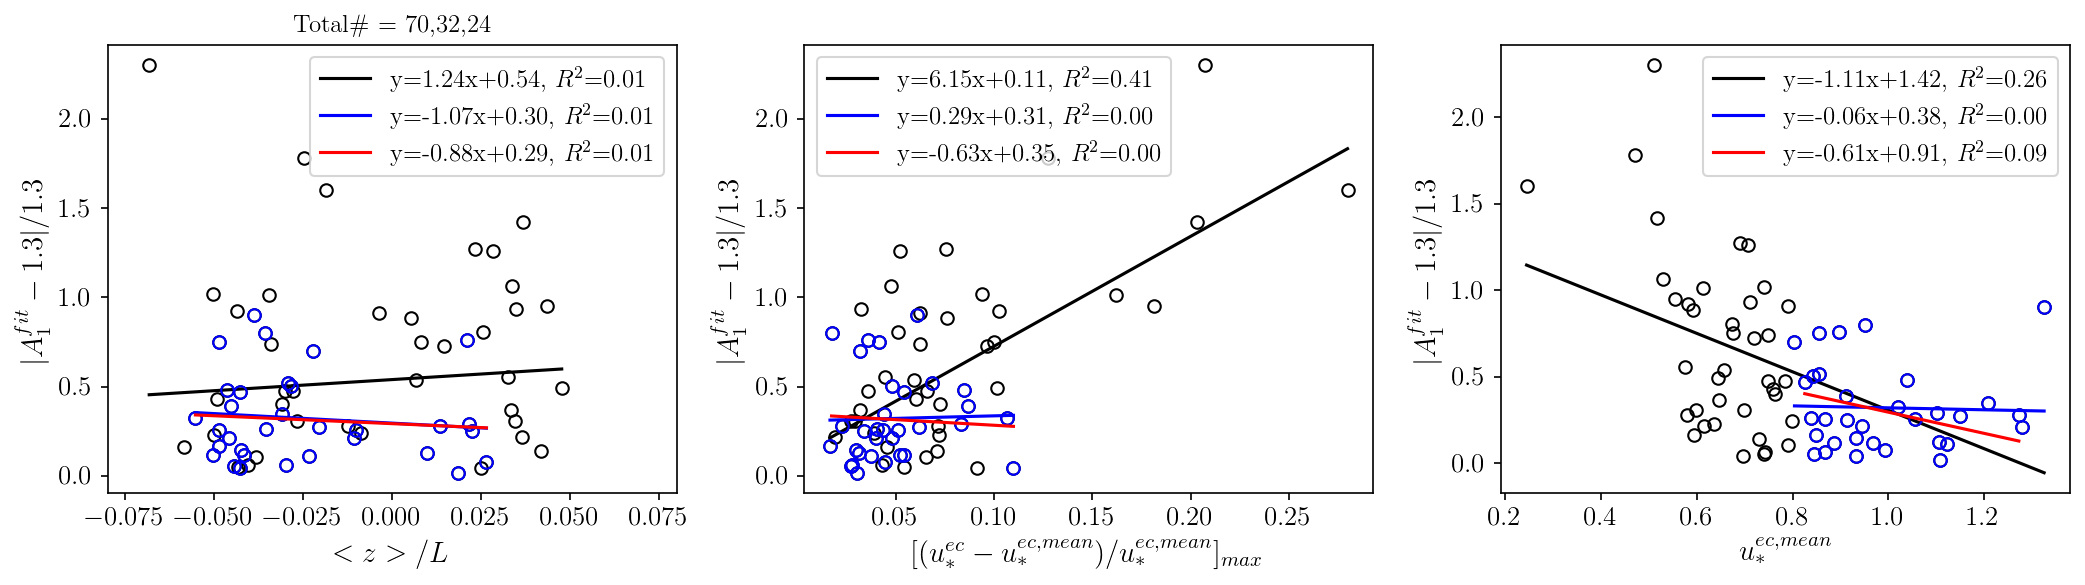

In [63]:
y_temp = abs(A1_ec_mean-1.3)/1.3
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
wdir_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
msk2 = np.logical_and(msk1,wdir_temp<4)
# msk = np.logical_and(r2_m2>0.9,wdir_temp<4)
# msk2 = np.logical_and(msk,r2_m1>0.6)

fig = plt.figure(figsize=(14,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(131) 
plt.plot(temp_stability[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability[msk],y_temp[msk])
x = np.sort(temp_stability[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.title(r'Total\# = {:},{:},{:}'.format(len(y_temp[msk]),len(y_temp[msk1]),len(y_temp[msk2])))
# plt.plot(temp_stability[np.logical_and(msk2,temp_stability<-0.06)],y_temp[np.logical_and(msk2,temp_stability<-0.06)],'o',
#          color = 'grey',markerfacecolor='none')
plt.xlim(-0.08,0.08)

ax1.plot(temp_stability[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(temp_stability[msk1],y_temp[msk1])
x = np.sort(temp_stability[msk1])
line = slope*x+intercept
ax1.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

# ax1.plot(temp_stability[msk2],y_temp[msk2],'o',color = 'r',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(temp_stability[msk2],y_temp[msk2])
x = np.sort(temp_stability[msk2])
line = slope*x+intercept
ax1.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax2 = fig.add_subplot(132) 
plt.plot(u_star_dif_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$[(u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}]_{max}$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk], y_temp[msk])
x = np.sort(u_star_dif_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax2.plot(u_star_dif_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk1],y_temp[msk1])
x = np.sort(u_star_dif_mean[msk1])
line = slope*x+intercept
ax2.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

# ax2.plot(u_star_dif_mean[msk2],y_temp[msk2],'o',color = 'r',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk2],y_temp[msk2])
x = np.sort(u_star_dif_mean[msk2])
line = slope*x+intercept
ax2.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.title(r'Total\# = {:}'.format(len(y_temp[msk2])))
# plt.plot(u_star_dif_mean[np.logical_and(msk2,temp_stability<-0.06)],y_temp[np.logical_and(msk2,temp_stability<-0.06)],'o',
#          color = 'grey',markerfacecolor='none')

ax3 = fig.add_subplot(133) 
plt.plot(u_star_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$u_*^{ec,mean}$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk], y_temp[msk])
x = np.sort(u_star_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax3.plot(u_star_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk1],y_temp[msk1])
x = np.sort(u_star_mean[msk1])
line = slope*x+intercept
ax3.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

# ax3.plot(u_star_mean[msk2],y_temp[msk2],'o',color = 'r',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(u_star_mean[msk2],y_temp[msk2])
x = np.sort(u_star_mean[msk2])
line = slope*x+intercept
ax3.plot(x, line, 'r', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

plt.savefig(PLOT_DIRECTORY + 'A_zol_u_star_ec_mean_vert_dev.jpg', dpi=200)

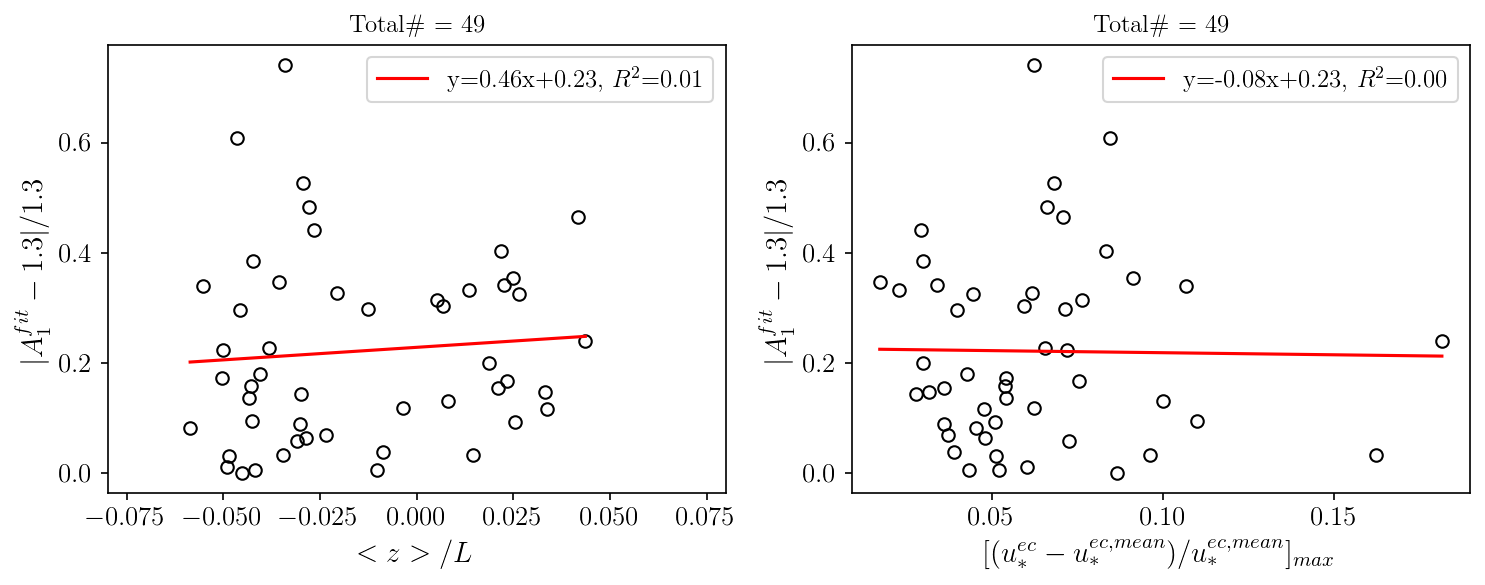

In [23]:
y_temp = abs(A1_ec_mean-1.3)/1.3

wdir_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
msk = np.logical_and(r2_m2>0.9,wdir_temp<4)
msk2 = np.logical_and(msk,r2_m1>0.6)
msk3 = np.logical_and(msk2,temp_stability>-0.06)

fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121) 
plt.plot(temp_stability[msk3],y_temp[msk3],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability[msk3],y_temp[msk3])
x = np.sort(temp_stability[msk3])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:}'.format(len(y_temp[msk3])))
# plt.plot(temp_stability[np.logical_and(msk2,temp_stability<-0.06)],y_temp[np.logical_and(msk2,temp_stability<-0.06)],'o',
#          color = 'grey',markerfacecolor='none')
plt.xlim(-0.08,0.08)

ax2 = fig.add_subplot(122) 
plt.plot(u_star_dif_mean[msk3],y_temp[msk3],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$[(u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}]_{max}$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk3], y_temp[msk3])
x = np.sort(u_star_dif_mean[msk3])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:}'.format(len(y_temp[msk3])))
# plt.plot(u_star_dif_mean[np.logical_and(msk2,temp_stability<-0.06)],y_temp[np.logical_and(msk2,temp_stability<-0.06)],'o',
#          color = 'grey',markerfacecolor='none')
plt.savefig(PLOT_DIRECTORY + 'A_zol_const2.jpg', dpi=200)

## A1_m1 vs IST and wdir ##

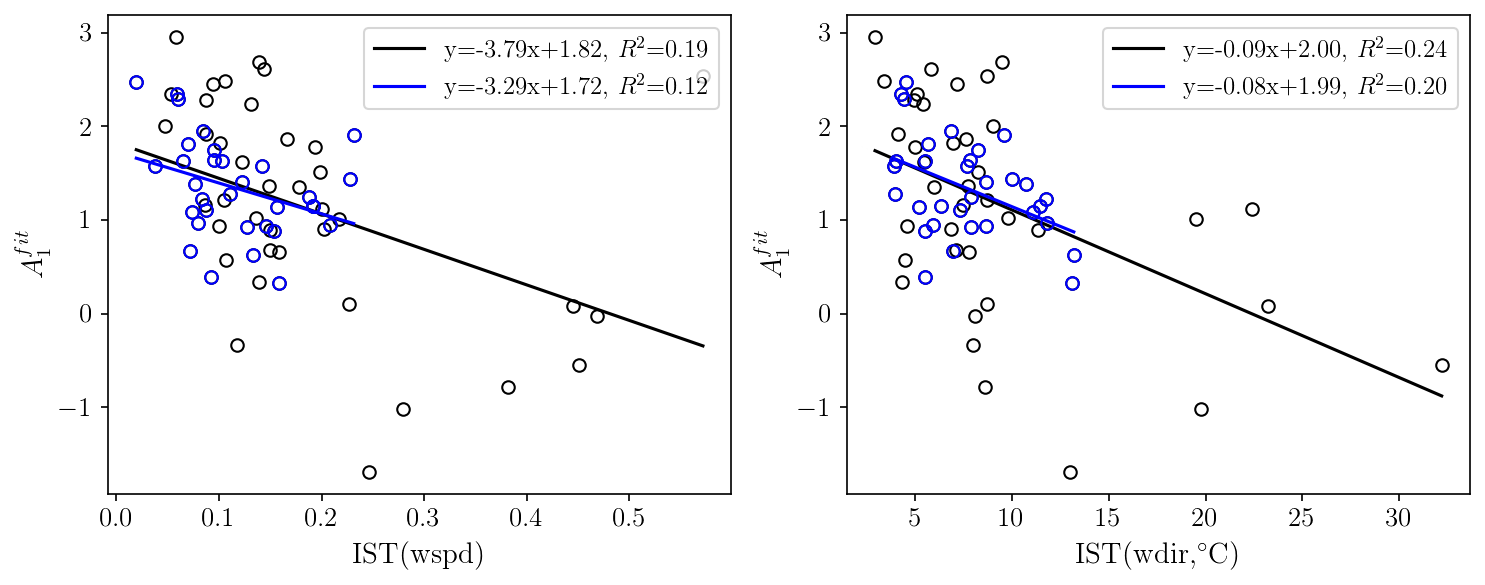

In [11]:
# y_temp = abs(A1_ec_mean-1.3)/1.3
y_temp = A1_ec_mean
ist = ist_before[:,5]
x_temp2 = np.nanmax(wind_diff_max_neutral, axis=1)

msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
wdir_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
msk2 = np.logical_and(msk1,wdir_temp<4)

fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
# ax1 = fig.add_subplot(131) 
# plt.plot(u_star_dif_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
# plt.xlabel(r'$[(u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}]_{max}$', fontsize=font_size)
# plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# # linear regression
# slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk], y_temp[msk])
# x = np.sort(u_star_dif_mean[msk])
# line = slope*x+intercept
# plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

# ax1.plot(u_star_dif_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
# slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk1],y_temp[msk1])
# x = np.sort(u_star_dif_mean[msk1])
# line = slope*x+intercept
# ax1.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
# plt.legend(fontsize=12)
# plt.title(r'Total\# = {:},{:}'.format(len(y_temp[msk]),len(y_temp[msk1])))

ax2 = fig.add_subplot(121) 
plt.plot(ist[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'IST(wspd)', fontsize=font_size)
plt.ylabel(r'$A_1^{fit}$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist[msk],y_temp[msk])
x = np.sort(ist[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax2.plot(ist[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(ist[msk1],y_temp[msk1])
x = np.sort(ist[msk1])
line = slope*x+intercept
ax2.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax3 = fig.add_subplot(122)
x_temp2 = np.nanmax(wind_diff_max_neutral, axis=1)
# y_msk = np.logical_and((abs(kappa_m2-0.4)/0.4)<1,A1_fit>0)
# ist = ist_before[:,5]
plt.plot(x_temp2[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'IST(wdir,$^\circ$C)', fontsize=font_size)
plt.ylabel(r'$A_1^{fit}$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp2[msk],y_temp[msk])
x = np.sort(x_temp2[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax3.plot(x_temp2[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp2[msk1],y_temp[msk1])
x = np.sort(x_temp2[msk1])
line = slope*x+intercept
ax3.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.savefig(PLOT_DIRECTORY + 'A1_IST.jpg', dpi=200)

## A1 vs change of wdir with height ##

In [ ]:
y_temp = abs(A1_ec_mean-1.3)/1.3
# y_temp = A1_ec_mean
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
wdir_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
msk2 = np.logical_and(msk1,wdir_temp<4)

fig = plt.figure(figsize=(10,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(121) 
plt.plot(u_star_dif_mean[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'$[(u_*^{ec}-u_*^{ec,mean})/u_*^{ec,mean}]_{max}$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk], y_temp[msk])
x = np.sort(u_star_dif_mean[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax1.plot(u_star_dif_mean[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(u_star_dif_mean[msk1],y_temp[msk1])
x = np.sort(u_star_dif_mean[msk1])
line = slope*x+intercept
ax1.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:},{:}'.format(len(y_temp[msk]),len(y_temp[msk1])))

ax2 = fig.add_subplot(122) 
x_temp3 = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
plt.plot(x_temp3[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp3[msk],y_temp[msk])
x = np.sort(x_temp3[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.xlabel(r'max change of wdir ($^\circ$C) with height', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
plt.plot(x_temp3[msk2],y_temp[msk2],'o',color = 'red',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp3[msk2],y_temp[msk2])
x = np.sort(x_temp3[msk2])
line = slope*x+intercept
plt.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
plt.title(r'Total\# = {:},{:}'.format(len(y_temp[msk]),len(y_temp[msk2])))
plt.savefig(PLOT_DIRECTORY + 'A1_vert_var.jpg', dpi=200)

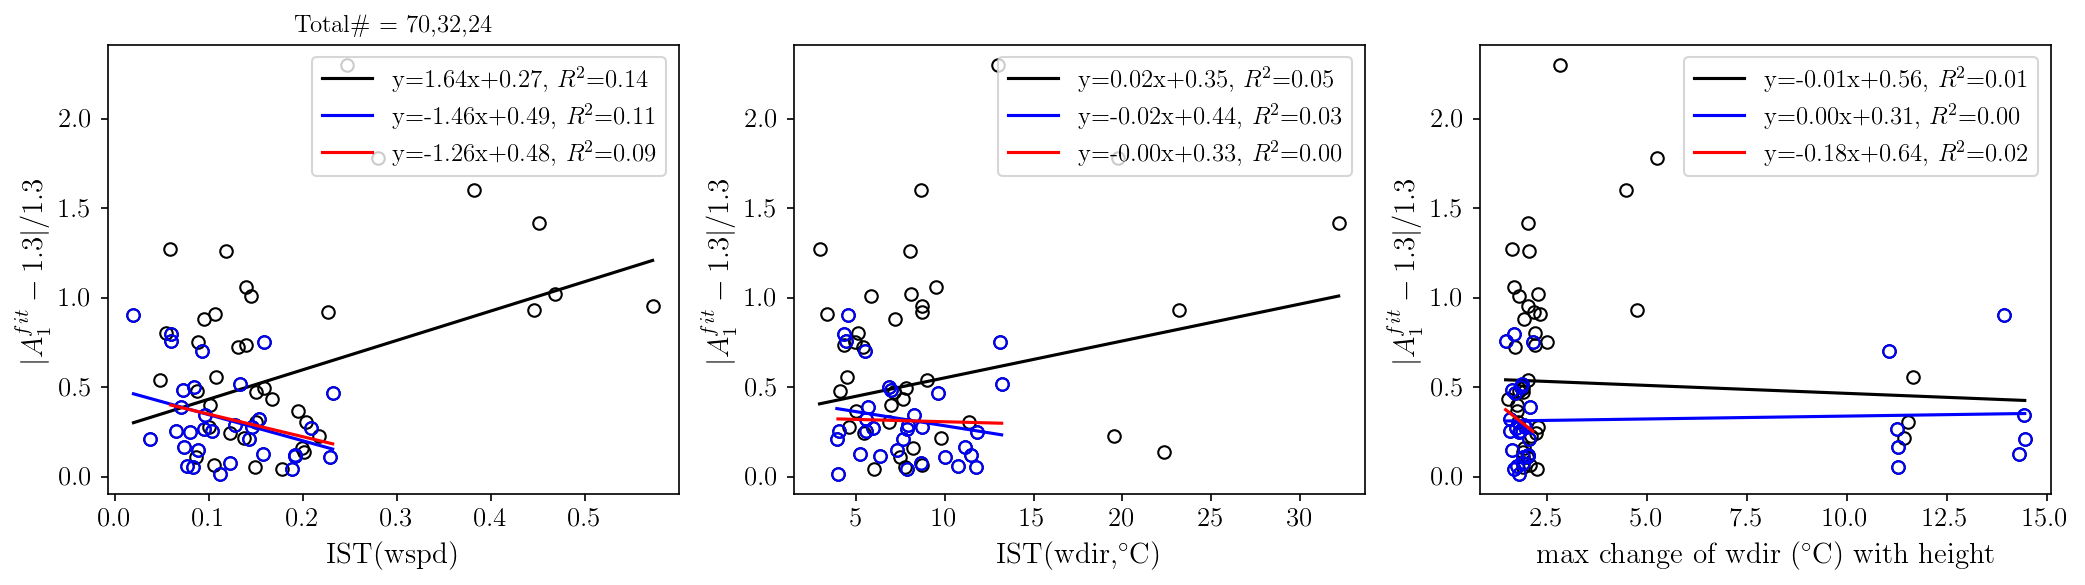

In [65]:
y_temp = abs(A1_ec_mean-1.3)/1.3
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
wdir_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
msk2 = np.logical_and(msk1,wdir_temp<4)

# y_msk = (abs(kappa_m2-0.4)/0.4)<1
y_plus = y_temp
# y_mean = np.nanmean(y_plus)
# y_sigma = np.nanstd(y_plus)
ist = ist_before[:,5]
# A_msk = A1_fit>0
# A1_fit = abs(A_fit-1.3)/1.3
# A_msk = ~np.isnan(A1_fit)
# A_mean = np.nanmean(A1_fit[A_msk])
fig = plt.figure(figsize=(14,4), dpi=150,tight_layout=True)

ax1 = fig.add_subplot(131) 
plt.plot(ist[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'IST(wspd)', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist[msk],y_temp[msk])
x = np.sort(ist[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax1.plot(ist[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(ist[msk1],y_temp[msk1])
x = np.sort(ist[msk1])
line = slope*x+intercept
ax1.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

slope, intercept,r,_,_ = stats.linregress(ist[msk2],y_temp[msk2])
x = np.sort(ist[msk2])
line = slope*x+intercept
ax1.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

plt.legend(fontsize=12)
plt.title(r'Total\# = {:},{:},{:}'.format(len(y_temp[msk]),len(y_temp[msk1]),len(y_temp[msk2])))
# plt.plot(ist[A1_fit<=0],y_temp[A1_fit<=0],'o',color = 'blue',markerfacecolor='none')
# plt.plot(ist[np.logical_and(ist>0.5,ist<0.6)],y_temp[np.logical_and(ist>0.5,ist<0.6)],'o',color = 'red',markerfacecolor='none')

ax2 = fig.add_subplot(132)
x_temp2 = np.nanmax(wind_diff_max_neutral, axis=1)
# y_msk = np.logical_and((abs(kappa_m2-0.4)/0.4)<1,A1_fit>0)
# ist = ist_before[:,5]
plt.plot(x_temp2[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'IST(wdir,$^\circ$C)', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp2[msk],y_temp[msk])
x = np.sort(x_temp2[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax2.plot(x_temp2[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp2[msk1],y_temp[msk1])
x = np.sort(x_temp2[msk1])
line = slope*x+intercept
ax2.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

slope, intercept,r,_,_ = stats.linregress(x_temp2[msk2],y_temp[msk2])
x = np.sort(x_temp2[msk2])
line = slope*x+intercept
ax2.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

plt.legend(fontsize=12)

ax3 = fig.add_subplot(133)
x_temp3 = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
# y_msk = np.logical_and(y_msk,wind_diff_max_neutral[:,5]<22)
# ist = ist_before[:,5]
plt.plot(x_temp3[msk],y_temp[msk],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'max change of wdir ($^\circ$C) with height', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp3[msk],y_temp[msk])
x = np.sort(x_temp3[msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

ax3.plot(x_temp3[msk1],y_temp[msk1],'o',color = 'blue',markerfacecolor='none')
slope, intercept,r,_,_ = stats.linregress(x_temp3[msk1],y_temp[msk1])
x = np.sort(x_temp3[msk1])
line = slope*x+intercept
ax3.plot(x, line, 'blue', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

slope, intercept,r,_,_ = stats.linregress(x_temp3[msk2],y_temp[msk2])
x = np.sort(x_temp3[msk2])
line = slope*x+intercept
ax3.plot(x, line, 'red', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))

plt.legend(fontsize=12)

plt.savefig(PLOT_DIRECTORY + 'A1_ist_wspd_wdir.jpg.jpg', dpi=200)

## distribution of A1 ##

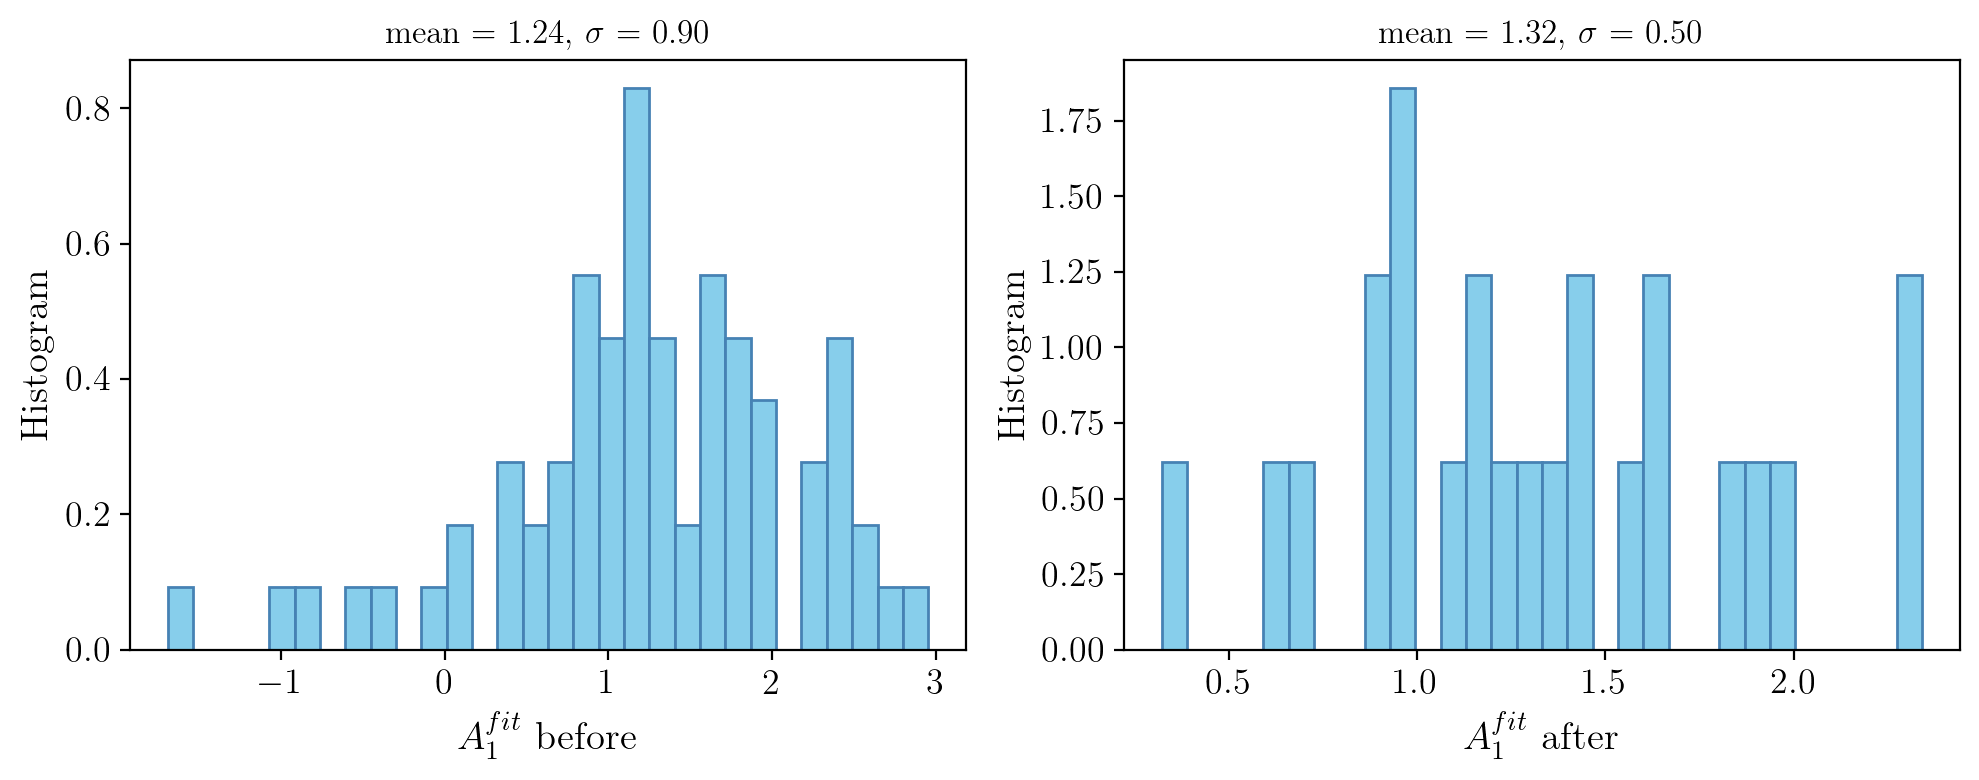

In [53]:
fig = plt.figure(figsize=(10,4), dpi=200,tight_layout=True)
ax1 = fig.add_subplot(121)
_ = plt.hist(A1_ec_mean[msk], color = "skyblue",edgecolor="steelblue", bins=30, density=True)
plt.xlabel(r'$A_1^{fit}$ before', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(A1_ec_mean[msk]),np.nanstd(A1_ec_mean[msk])))
# plt.xlim(0.2,1.8)

ax2 = fig.add_subplot(122)
_ = plt.hist(A1_ec_mean[msk2], color = "skyblue",edgecolor="steelblue", bins=30, density=True)
plt.xlabel(r'$A_1^{fit}$ after', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(A1_ec_mean[msk2]),np.nanstd(A1_ec_mean[msk2])))
# plt.xlim(0.2,1.8)

plt.savefig(PLOT_DIRECTORY + 'A1_distri.jpg')

## Distribution of ustar, kappa, A1 ##

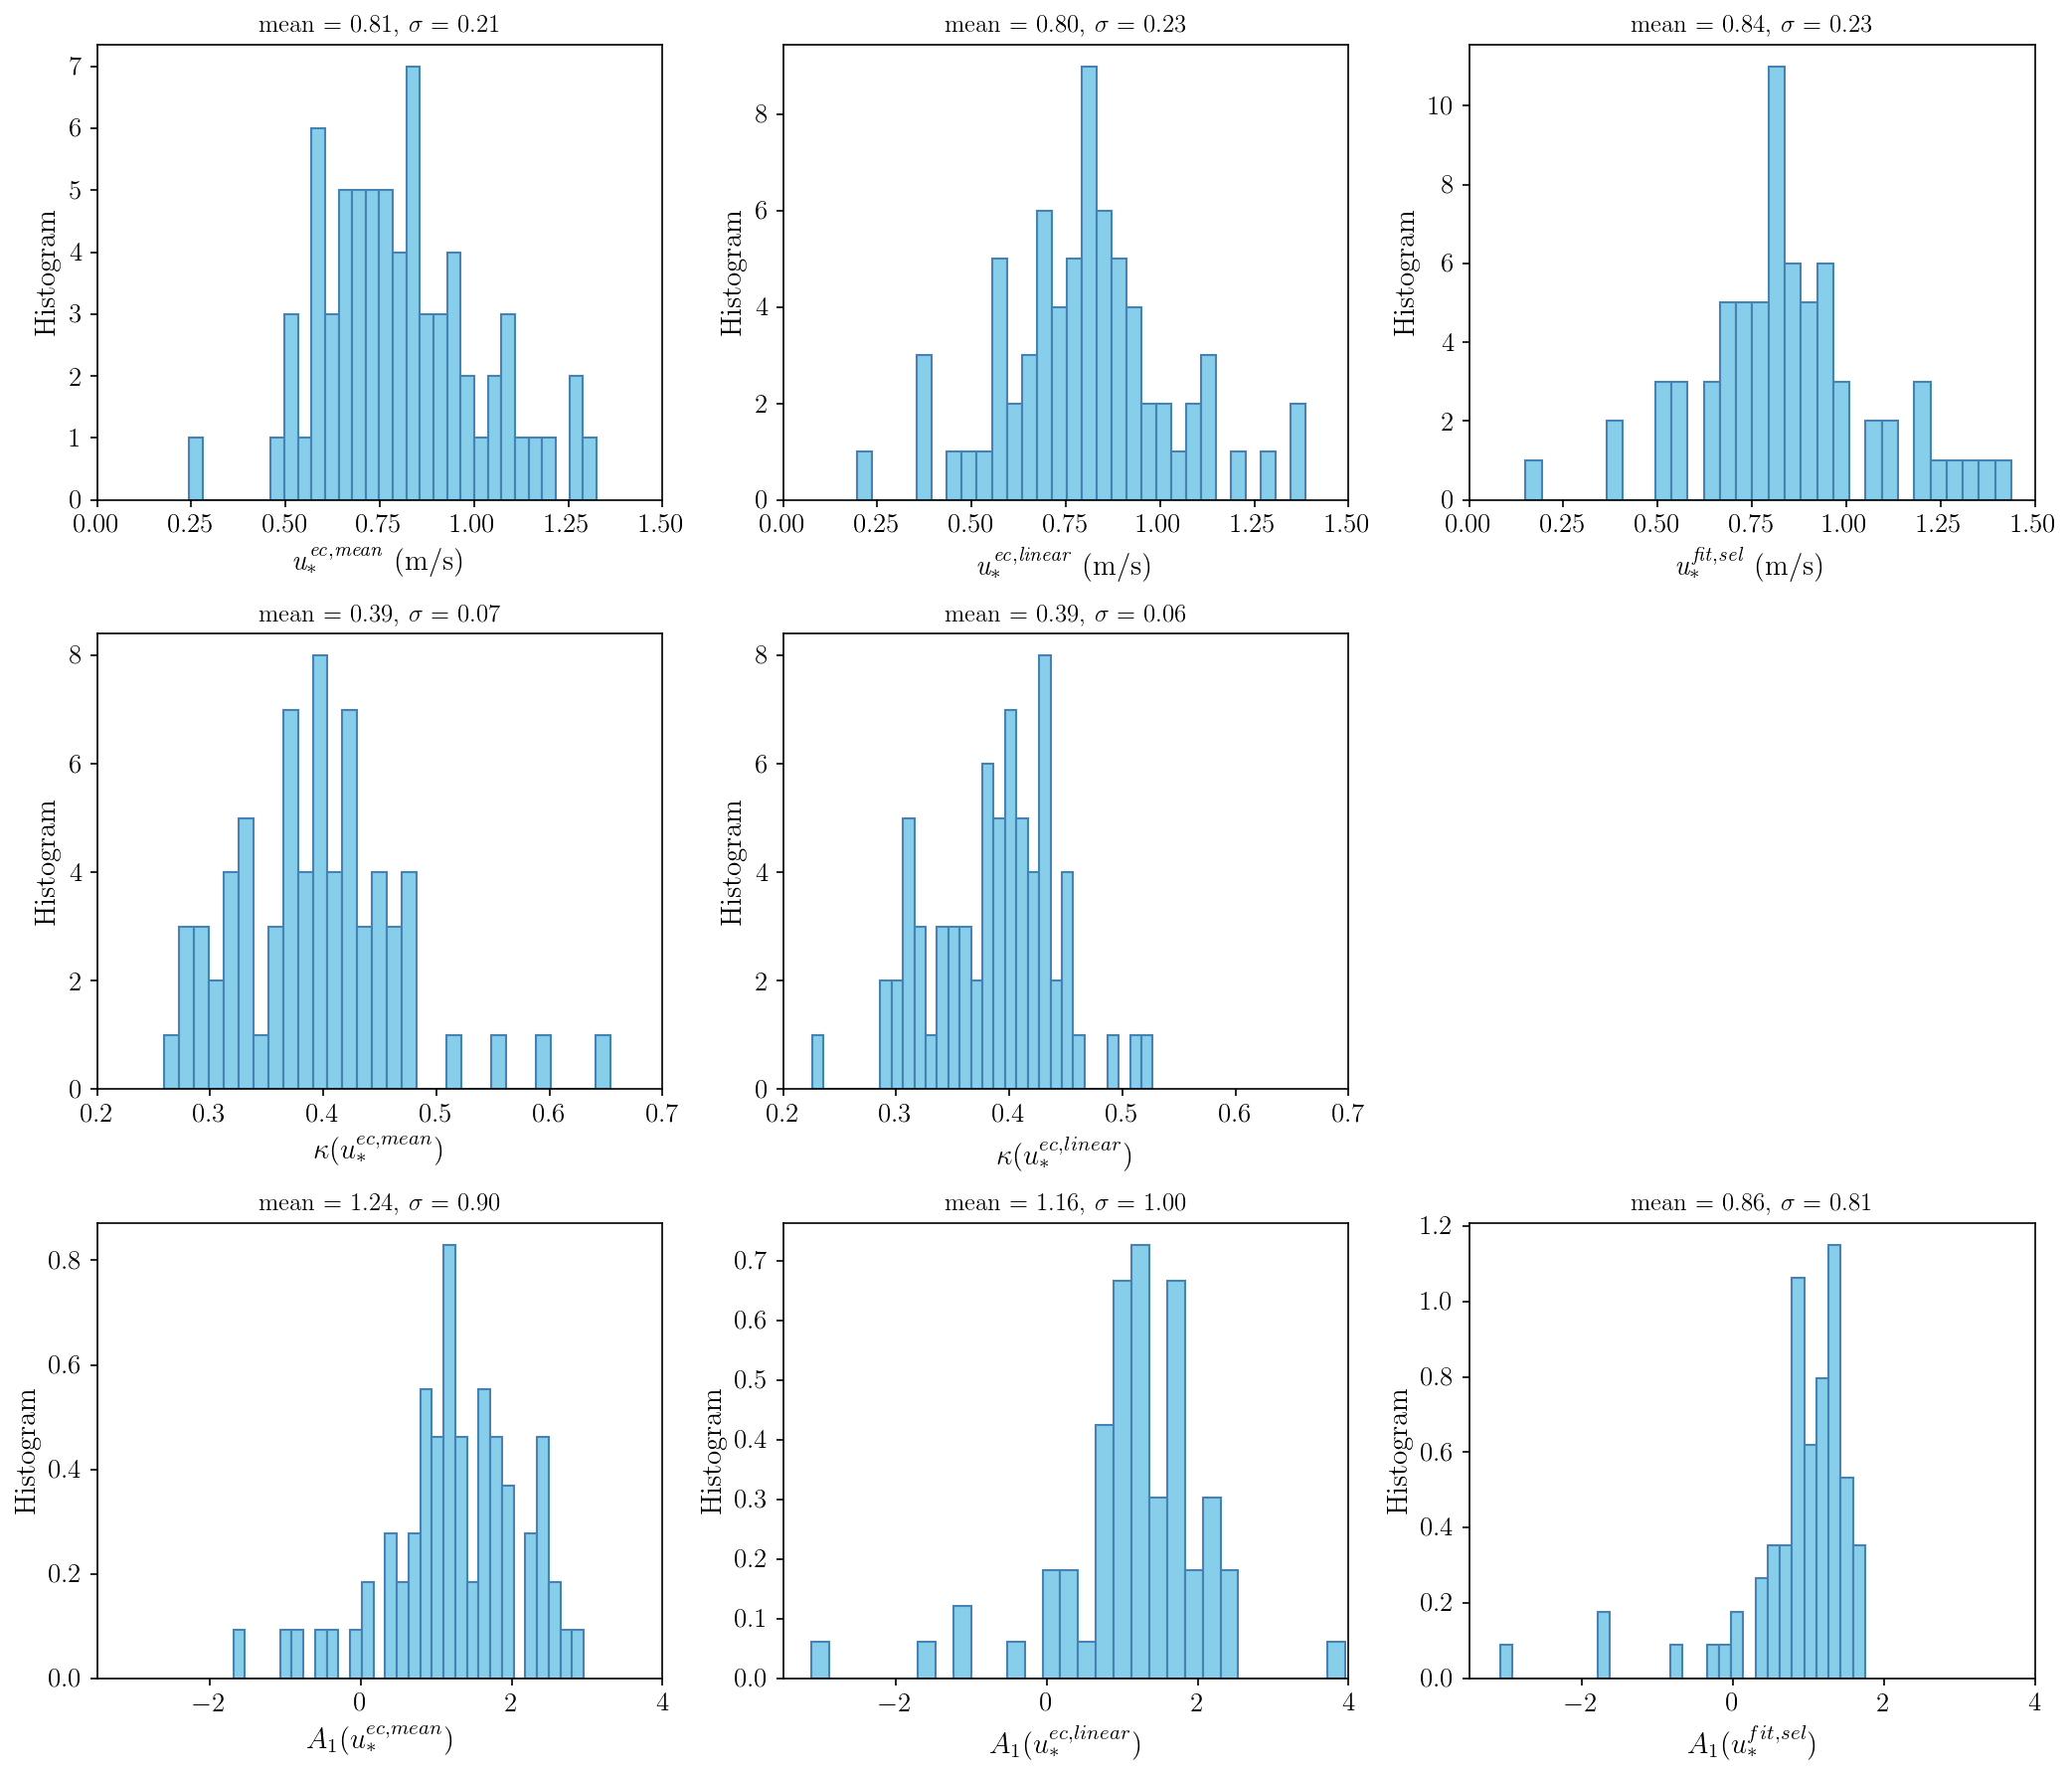

In [69]:
fig = plt.figure(figsize=(14,12), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(331)
_ = plt.hist(u_star_mean[msk], color = "skyblue",edgecolor="steelblue", bins=30)  # arguments are passed to np.histogram
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(u_star_mean[msk]),np.nanstd(u_star_mean[msk])))
plt.xlabel(r'$\it u_*^{ec,mean}$ (m/s)', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.xlim(0,1.5)

ax2 = fig.add_subplot(332)
_ = plt.hist(u_star_fit[msk], color = "skyblue",edgecolor="steelblue", bins=30)  # arguments are passed to np.histogram
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(u_star_fit[msk]),np.nanstd(u_star_fit[msk])))
plt.xlabel(r'$\it u_*^{ec,linear}$ (m/s)', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.xlim(0,1.5)

ax3 = fig.add_subplot(333)
_ = plt.hist(u_star_m1_sel[msk], color = "skyblue",edgecolor="steelblue", bins=30)  # arguments are passed to np.histogram
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(u_star_m1_sel[msk]),np.nanstd(u_star_m1_sel[msk])))
plt.xlabel(r'$\it u_*^{fit,sel}$ (m/s)', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.xlim(0,1.5)

ax4 = fig.add_subplot(334)
_ = plt.hist(kappa_m2_ec_mean[msk], color = "skyblue",edgecolor="steelblue", bins=30)  # arguments are passed to np.histogram
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(kappa_m2_ec_mean[msk]),np.nanstd(kappa_m2_ec_mean[msk])))
plt.xlabel(r'$\kappa(u_*^{ec,mean})$', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.xlim(0.2,0.7)

ax5 = fig.add_subplot(335)
_ = plt.hist(kappa_m2[msk], color = "skyblue",edgecolor="steelblue", bins=30)  # arguments are passed to np.histogram
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(kappa_m2[msk]),np.nanstd(kappa_m2[msk])))
plt.xlabel(r'$\kappa(u_*^{ec,linear})$', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.xlim(0.2,0.7)

ax7 = fig.add_subplot(337)
_ = plt.hist(A1_ec_mean[msk], color = "skyblue",edgecolor="steelblue", bins=30, density=True)
plt.xlabel(r'$A_1(u_*^{ec,mean})$', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(A1_ec_mean[msk]),np.nanstd(A1_ec_mean[msk])))
plt.xlim(-3.5,4)

ax8 = fig.add_subplot(338)
_ = plt.hist(A1_fit[msk], color = "skyblue",edgecolor="steelblue", bins=30, density=True)
plt.xlabel(r'$A_1(u_*^{ec,linear})$', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(A1_fit[msk]),np.nanstd(A1_fit[msk])))
plt.xlim(-3.5,4)

ax9 = fig.add_subplot(339)
_ = plt.hist(A1_m1[msk], color = "skyblue",edgecolor="steelblue", bins=30, density=True)
plt.xlabel(r'$A_1(u_*^{fit,sel})$', fontsize=font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)
plt.title("mean = {:.2f}, $\sigma$ = {:.2f}".format(np.nanmean(A1_m1[msk]),np.nanstd(A1_m1[msk])))
plt.xlim(-3.5,4)
plt.savefig(PLOT_DIRECTORY + 'distri_ustar_kappa_A1.jpg')

## A1 and Kappa relation ##

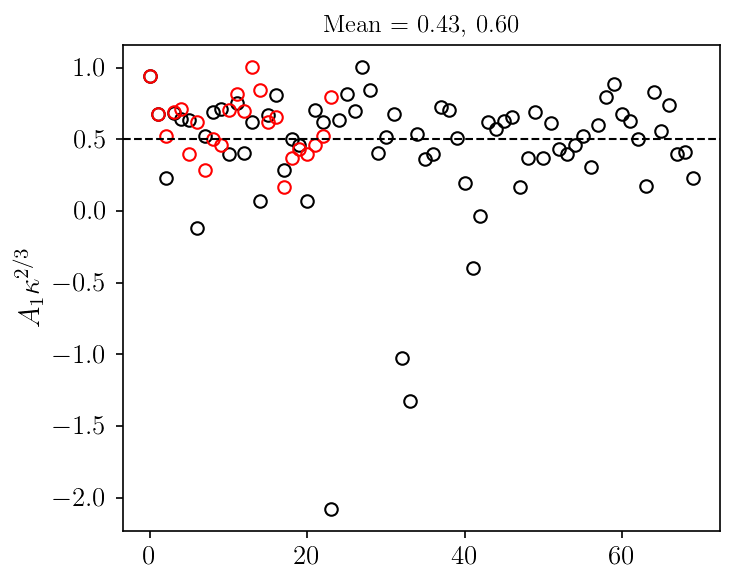

In [52]:
msk = r2_m2>0.85
msk1 = np.logical_and(msk,u_star_mean>0.8)
wdir_temp = np.nanmax(abs(np.diff(wdir_neutral[:,list_sel_m2],axis=1)),axis=1)
msk2 = np.logical_and(msk1,wdir_temp<4)
y = A1_m1*kappa_m2_ec_mean**(2/3)

fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111)
plt.plot(y[A1_m1<5],'o',color = 'k',markerfacecolor='none')
plt.plot(y[msk2],'o',color = 'red',markerfacecolor='none')
plt.axhline(y=0.5, color='k', linestyle='--', linewidth=1)

# plt.ylabel('$A_1$', fontsize=font_size)
plt.ylabel('$A_1\kappa^{2/3}$', fontsize=font_size)
plt.title(r'Mean = {:.2f}, {:.2f}'.format(np.nanmean(y[A1_m1<5]),np.nanmean(y[msk2])))
plt.savefig(PLOT_DIRECTORY + 'A1_m1_kappa_2_3.jpg', dpi=200)

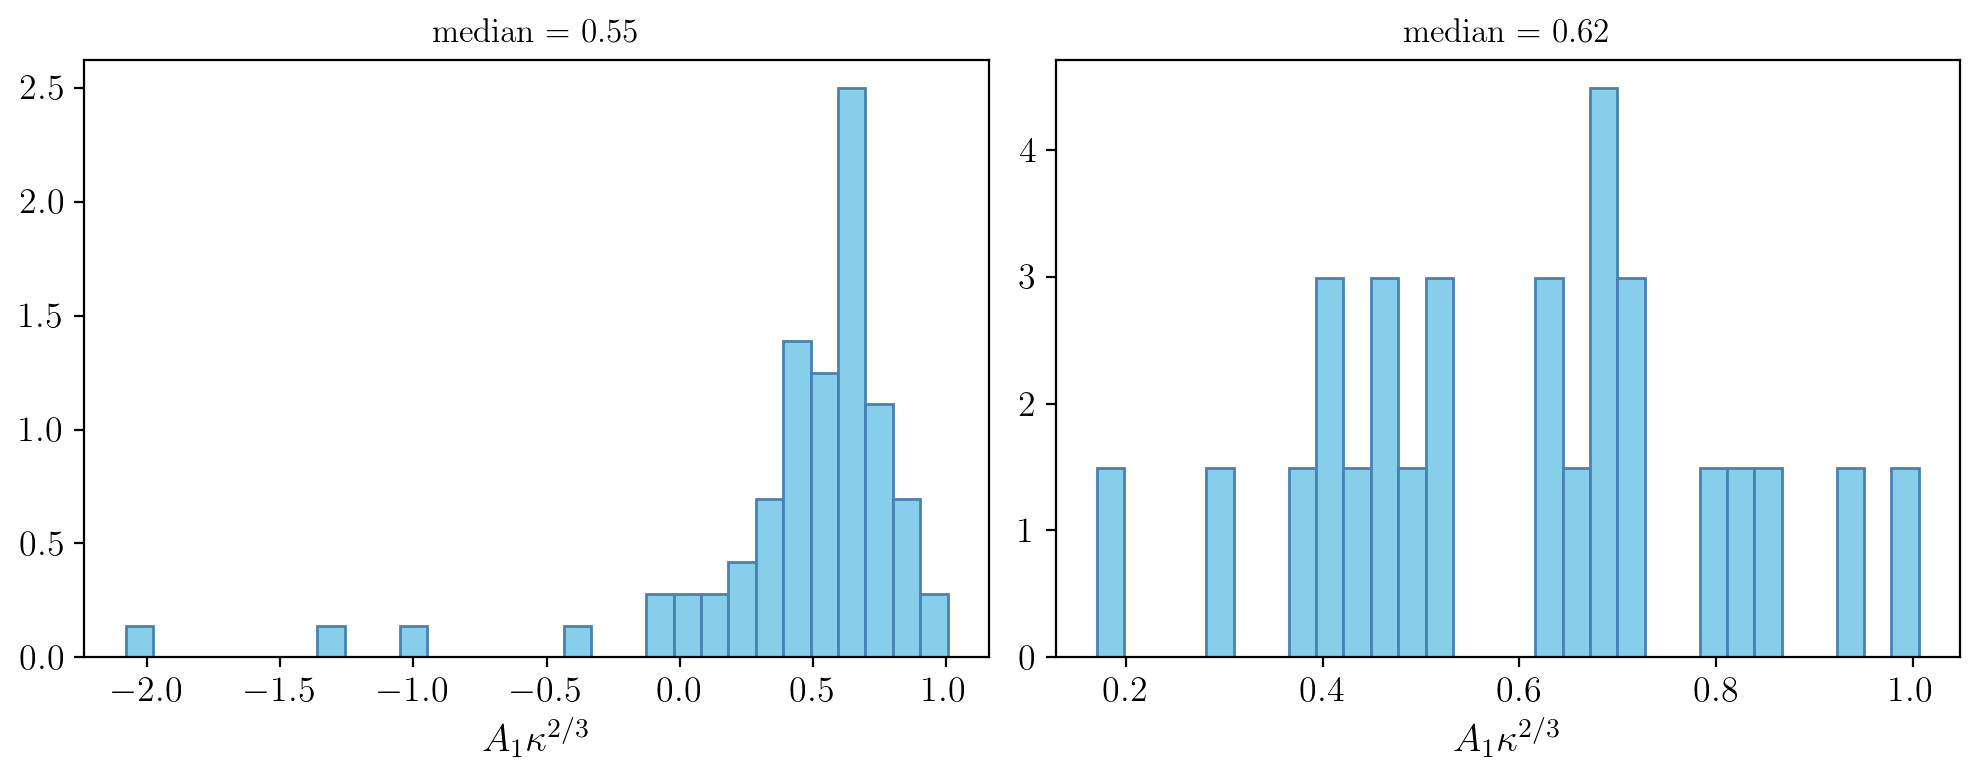

In [50]:
fig = plt.figure(figsize=(10,4), dpi=200,tight_layout=True)
ax1 = fig.add_subplot(121)
_ = plt.hist(y[msk], color = "skyblue",edgecolor="steelblue", bins=30, density=True)
# plt.xlabel(r'$A_1^{fit} before$', fontsize=font_size)
plt.xlabel('$A_1\kappa^{2/3}$', fontsize = font_size)
plt.title("median = {:.2f}".format(ndimage.median(y[msk])))

ax1 = fig.add_subplot(122)
_ = plt.hist(y[msk2], color = "skyblue",edgecolor="steelblue", bins=30, density=True)
# plt.xlabel(r'$A_1^{fit} before$', fontsize=font_size)
plt.xlabel('$A_1\kappa^{2/3}$', fontsize = font_size)
plt.title("median = {:.2f}".format(ndimage.median(y[msk2])))
plt.savefig(PLOT_DIRECTORY + 'A1_m1_kappa_2_3_distri.jpg', dpi=200)

## A1_m1 vs stability, IST, R2, u*_dev ##

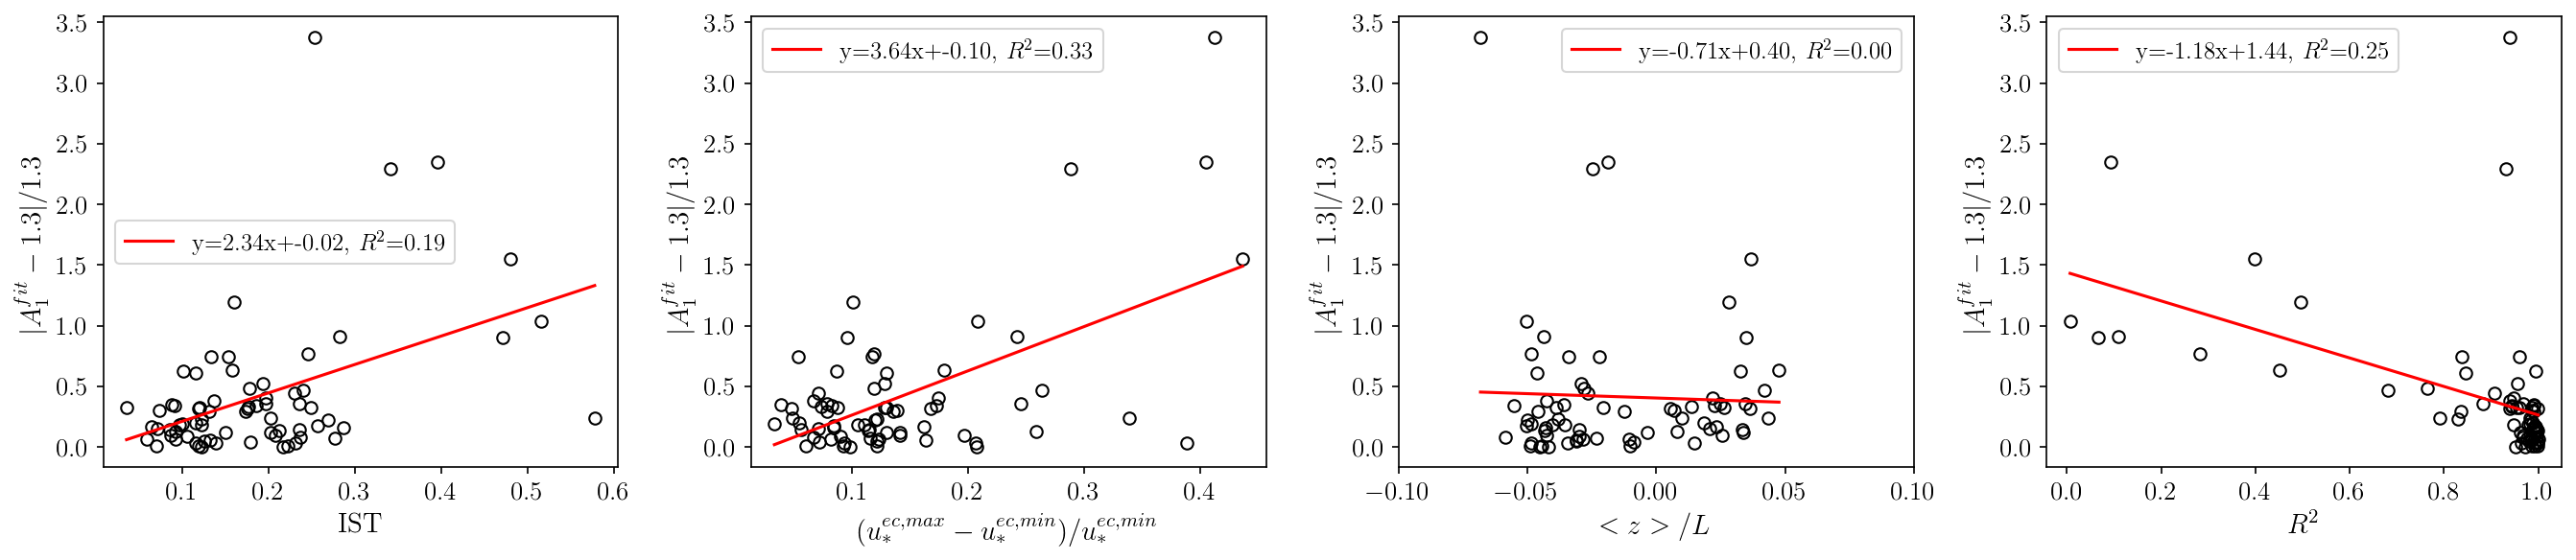

In [14]:
y_temp = abs(A1_m1-1.3)/1.3
y_msk = (abs(kappa_m2-0.4)/0.4)<1
y_plus = y_temp[y_msk]
y_mean = np.nanmean(y_plus)
y_sigma = np.nanstd(y_plus)

# A_msk = A1_fit>0
# A1_fit = abs(A_fit-1.3)/1.3
# A_msk = ~np.isnan(A1_fit)
# A_mean = np.nanmean(A1_fit[A_msk])
fig = plt.figure(figsize=(18,4), dpi=150,tight_layout=True)

ax1 = fig.add_subplot(141) 
ist = np.nanmean(ist_before, axis=1)
plt.plot(ist[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'IST', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist[y_msk], y_plus)
x = np.sort(ist[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# plt.plot(ist[A1_fit<=0],A1_fit[A1_fit<=0],'o',color = 'blue',markerfacecolor='none')

ax2 = fig.add_subplot(142) 
plt.plot(u_star_m2_dif[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$(u_*^{ec,max}-u_*^{ec,min})/u_*^{ec,min}$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(u_star_m2_dif[y_msk], y_plus)
x = np.sort(u_star_m2_dif[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax3 = fig.add_subplot(143) 
plt.plot(temp_stability[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'\rm $<z>/L$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
plt.xlim(-0.1,0.1)
# linear regression
slope, intercept,r,_,_ = stats.linregress(temp_stability[y_msk], y_plus)
x = np.sort(temp_stability[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax4 = fig.add_subplot(144) 
plt.plot(r2_m1[y_msk],y_plus,'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'$R^2$', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(r2_m1[y_msk], y_plus)
x = np.sort(r2_m1[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

## Wind direction ditribution ##

Text(0, 0.5, '\\rm Histogram')

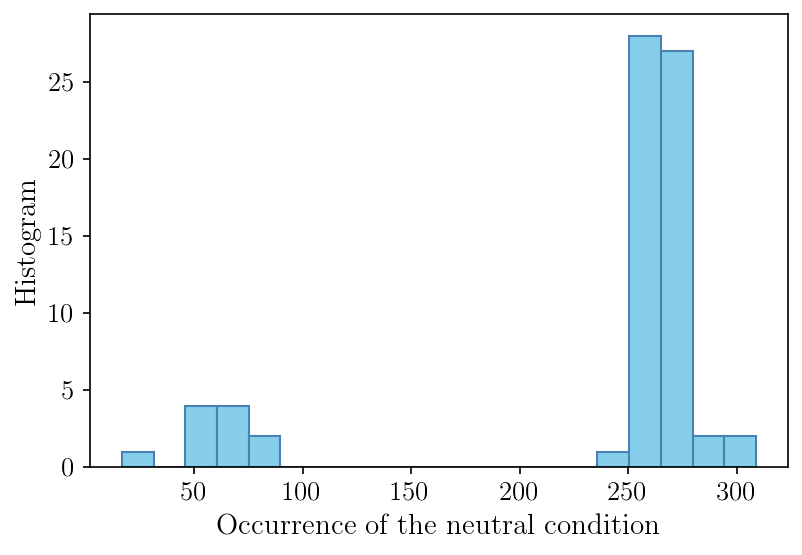

In [32]:
plt.figure(figsize=(6, 4), dpi=150)
_ = plt.hist(wind_ang_neutral, color = "skyblue",edgecolor="steelblue", bins=20)  # arguments are passed to np.histogram
# plt.text(1,10,r'Total\# = {:}'.format(len(neutral_case)), fontsize = 16)
plt.xlabel(r'\rm Occurrence of the neutral condition', fontsize = font_size)
plt.ylabel(r'\rm Histogram', fontsize = font_size)

In [35]:
from statistics import mode
mode(wind_ang_neutral)

257.4187702089568

## A1 vs wind angle ##

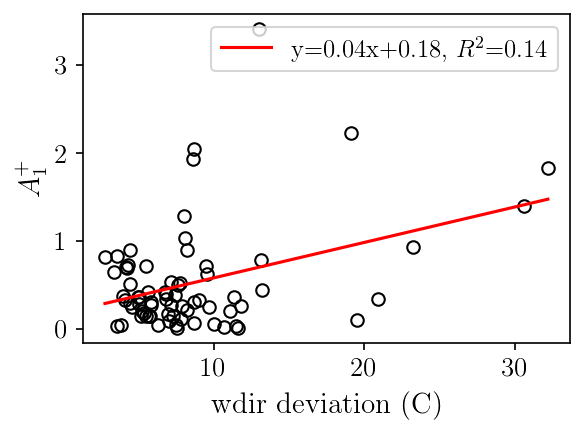

In [11]:
fig = plt.figure(figsize=(4,3), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111)
x_temp = wind_diff_max_neutral[:,5] # level 6
y_temp = abs(A1_fit-1.3)/1.3
plt.plot(x_temp,y_temp,'o',color = 'k',markerfacecolor='none')
# plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
# plt.axhline(y=0.4, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'wdir deviation (C)', fontsize=font_size)
plt.ylabel(r'$A_1^+$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp, y_temp)
x = np.sort(x_temp)
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

## IST VS wind angle, IST VS A1, wind angle VS A1 ##

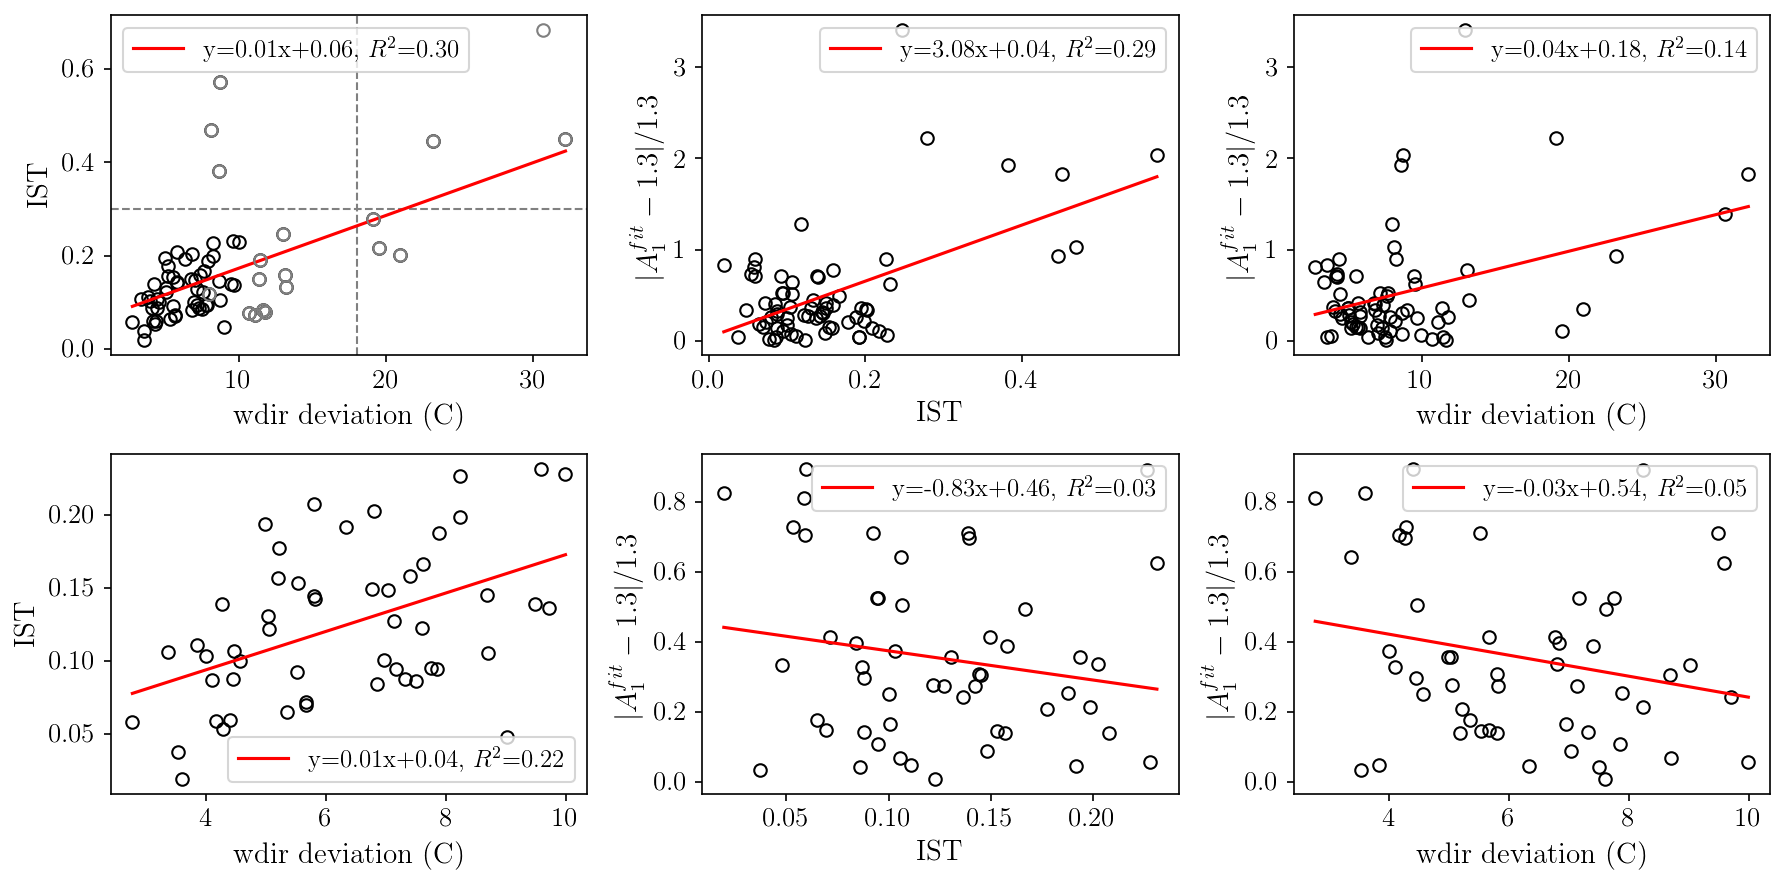

In [33]:
y_msk = (abs(kappa_m2-0.4)/0.4)<1

fig = plt.figure(figsize=(12,6), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(231)
x_temp = wind_diff_max_neutral[:,5]
y_temp = ist_before[:,5]
plt.axvline(x=18, color='grey', linestyle='--', linewidth=1)
plt.axhline(y=0.3, color='grey', linestyle='--', linewidth=1)
plt.plot(x_temp[y_msk],y_temp[y_msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'wdir deviation (C)', fontsize=font_size)
plt.ylabel(r'IST', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp[y_msk],y_temp[y_msk])
x = np.sort(x_temp[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax2 = fig.add_subplot(232) 
ist = ist_before[:,5]
A1_plus = abs(A1_fit-1.3)/1.3
plt.plot(ist[y_msk],A1_plus[y_msk],'o',color = 'k',markerfacecolor='none')
# plt.axhline(y=y_mean, color='grey', linestyle='--', linewidth=1)
plt.xlabel(r'IST', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist[y_msk],A1_plus[y_msk])
x = np.sort(ist[y_msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax3 = fig.add_subplot(233)
x_temp = wind_diff_max_neutral[:,5] # level 6
# y_temp = abs(A1_fit-1.3)/1.3
plt.plot(x_temp,A1_plus,'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'wdir deviation (C)', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp, A1_plus)
x = np.sort(x_temp)
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax4 = fig.add_subplot(234)
msk1 = np.logical_and(wind_diff_max_neutral[:,5]<10,ist_before[:,5]<0.3)
# msk = np.logical_and(msk1,A1_plus<3)
msk = np.logical_and(msk1,A1_fit>0)
x_temp = wind_diff_max_neutral[msk,5]
y_temp = ist_before[msk,5]
plt.plot(x_temp,y_temp,'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'wdir deviation (C)', fontsize=font_size)
plt.ylabel(r'IST', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp, y_temp)
x = np.sort(x_temp)
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax1.plot(wind_diff_max_neutral[~msk,5],ist_before[~msk,5],'o',color = 'grey',markerfacecolor='none')

ax5 = fig.add_subplot(235) 
ist = ist_before[msk,5]
y_temp = A1_plus[msk]
plt.plot(ist,y_temp,'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'IST', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(ist,y_temp)
x = np.sort(ist)
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

ax6 = fig.add_subplot(236) 
x_temp = wind_diff_max_neutral[msk,5]
y_temp = A1_plus[msk]
plt.plot(x_temp,y_temp,'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'wdir deviation (C)', fontsize=font_size)
plt.ylabel(r'$|A_1^{fit}-1.3|/1.3$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(x_temp,y_temp)
x = np.sort(x_temp)
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)

# plt.savefig(PLOT_DIRECTORY + 'IST_wdir_A1.jpg', dpi=200)

## A1 vs Re ##

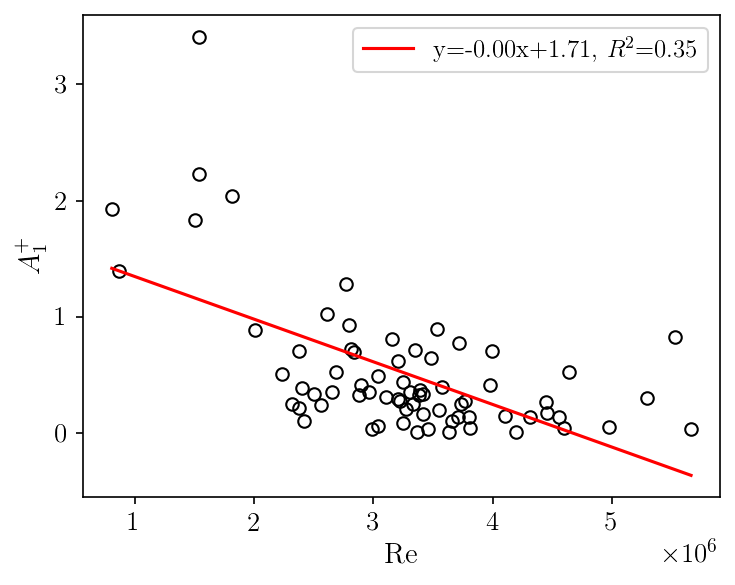

In [28]:
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111)
y_temp = abs(A1_fit-1.3)/1.3
x_msk = np.logical_and(re_z<1e+11,_)
plt.plot(re_z[x_msk],y_temp[x_msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'Re', fontsize=font_size)
plt.ylabel(r'$A_1^+$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(re_z[x_msk], y_temp[x_msk])
x = np.sort(re_z[x_msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# ax1.set_xscale('log')

## Kappa vs Re ##

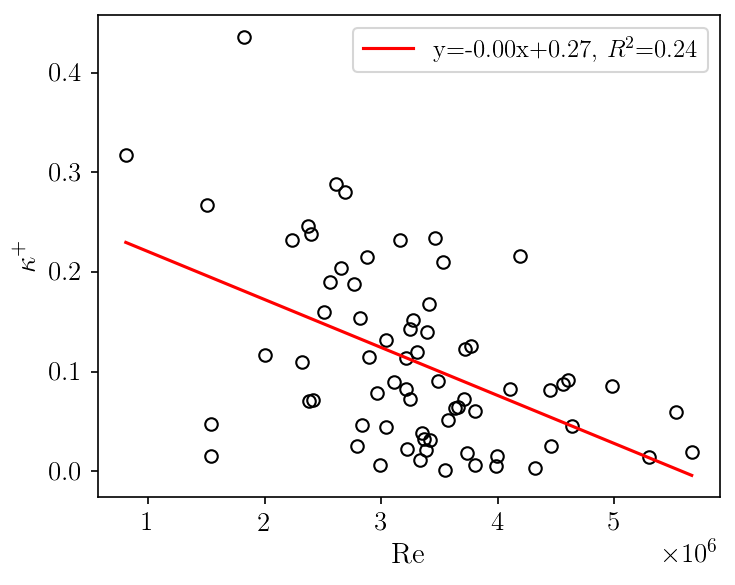

In [29]:
fig = plt.figure(figsize=(5,4), dpi=150,tight_layout=True)
ax1 = fig.add_subplot(111)
y_temp = abs(kappa_m2-0.4)/0.4
# x_msk = ~np.isnan(re)
x_msk = np.logical_and(re_z<1e+11,y_temp<np.nanmax(y_temp))
plt.plot(re_z[x_msk],y_temp[x_msk],'o',color = 'k',markerfacecolor='none')
plt.xlabel(r'Re', fontsize=font_size)
plt.ylabel(r'$\kappa^+$', fontsize=font_size)
# linear regression
slope, intercept,r,_,_ = stats.linregress(re_z[x_msk], y_temp[x_msk])
x = np.sort(re_z[x_msk])
line = slope*x+intercept
plt.plot(x, line, 'k', label='y={:.2f}x+{:.2f}, $R^2$={:.2f}'.format(slope,intercept,r**2))
plt.legend(fontsize=12)
# ax1.set_xscale('log')

## Reynolds stress VS z+ ##

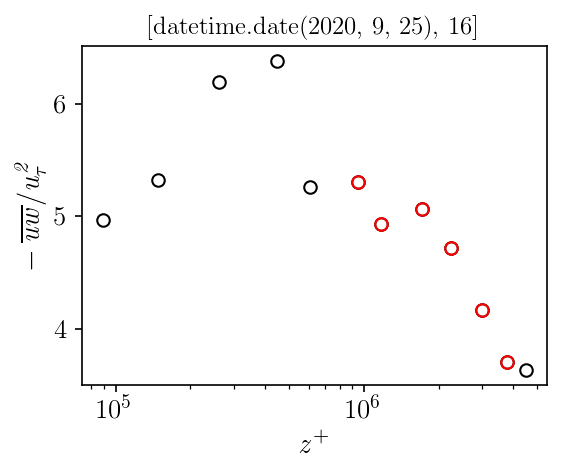

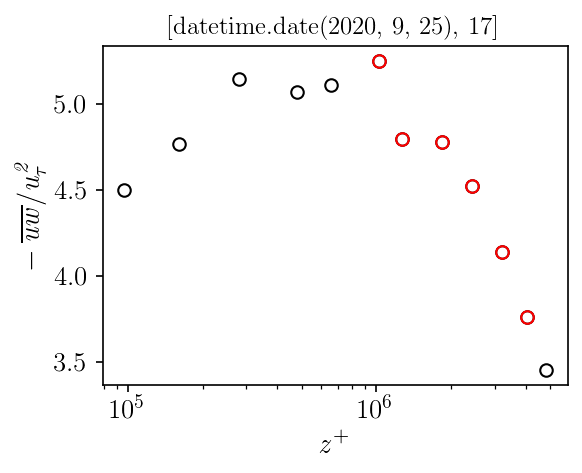

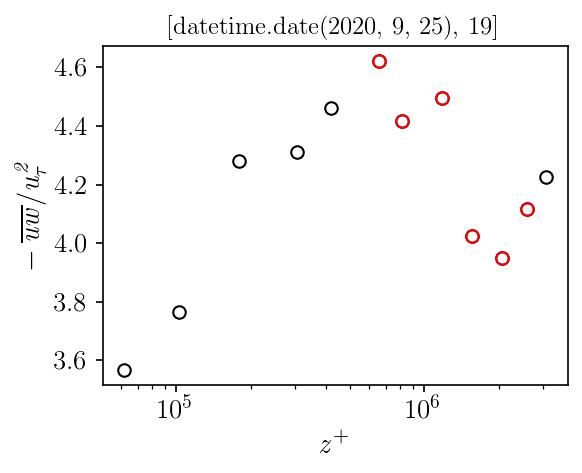

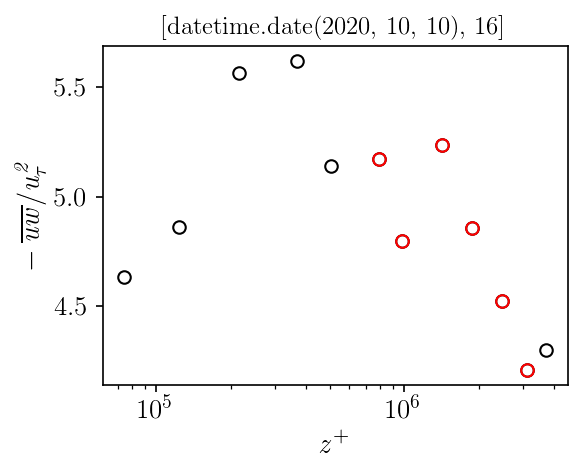

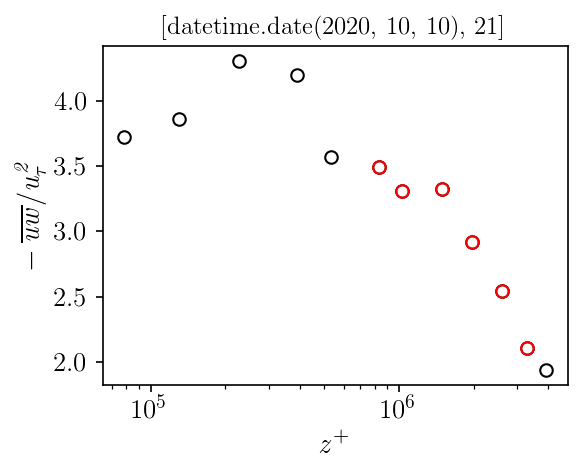

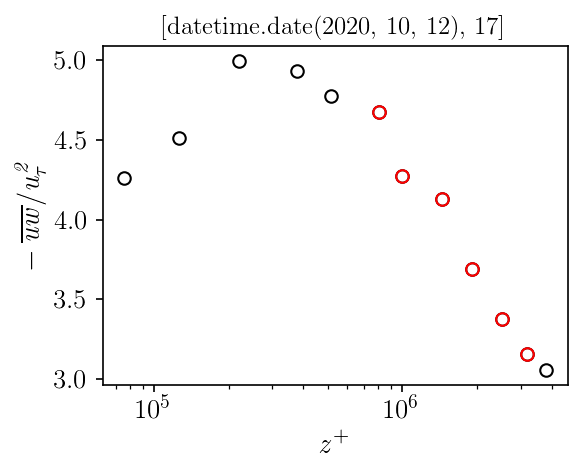

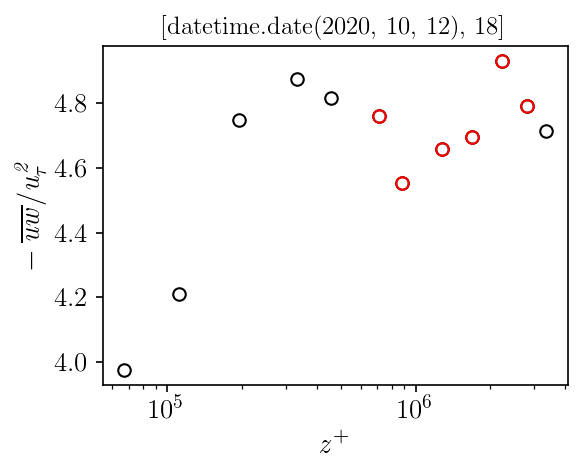

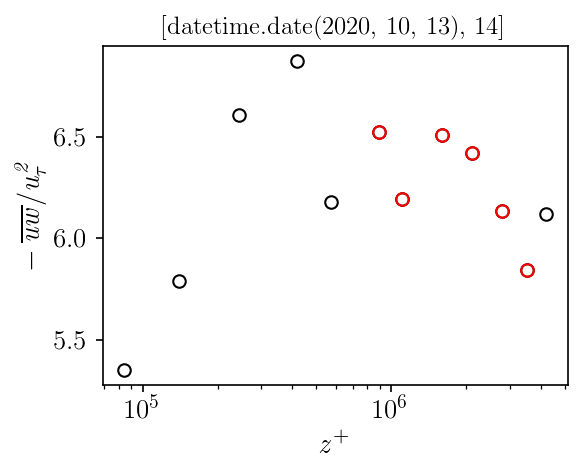

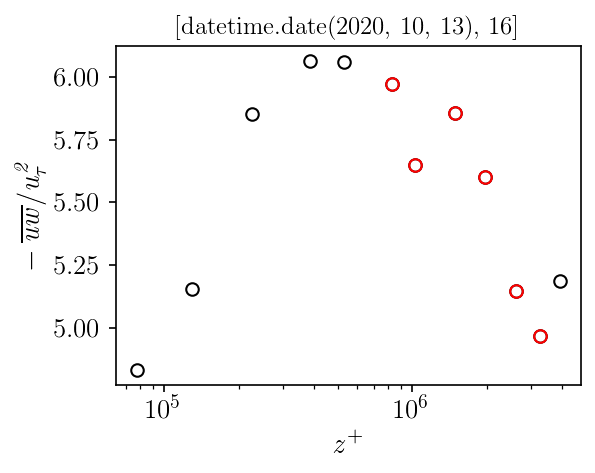

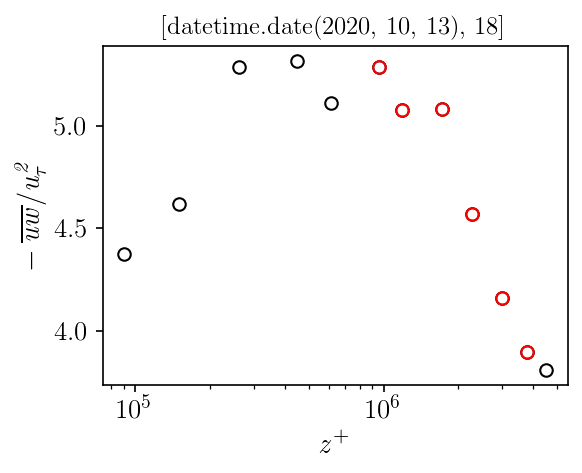

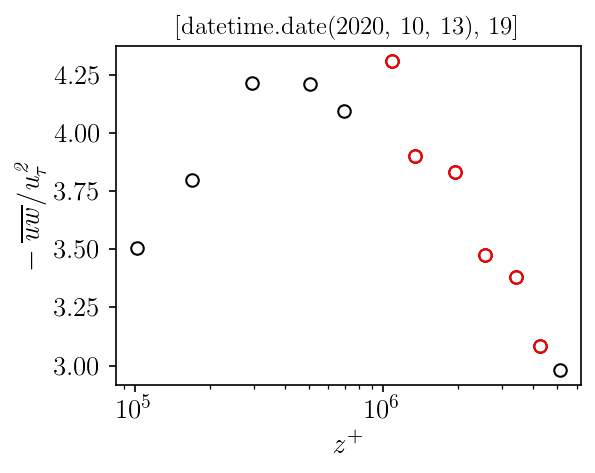

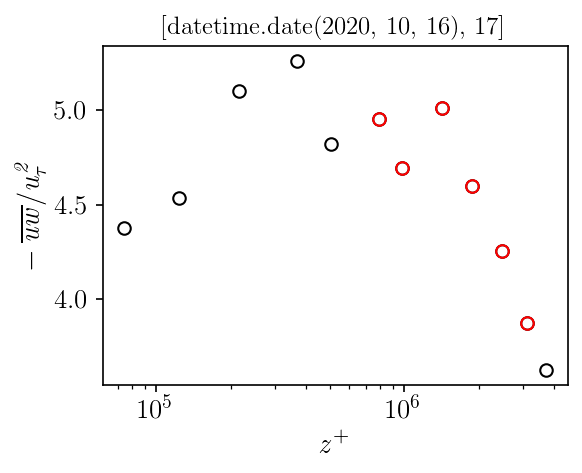

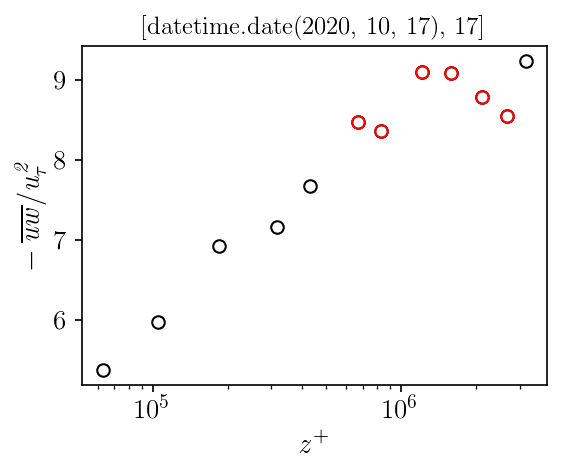

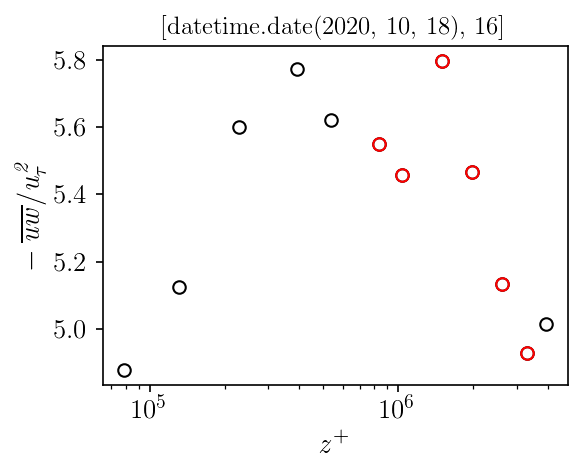

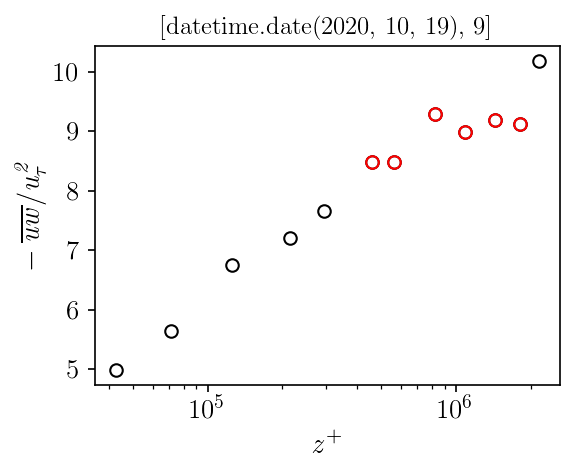

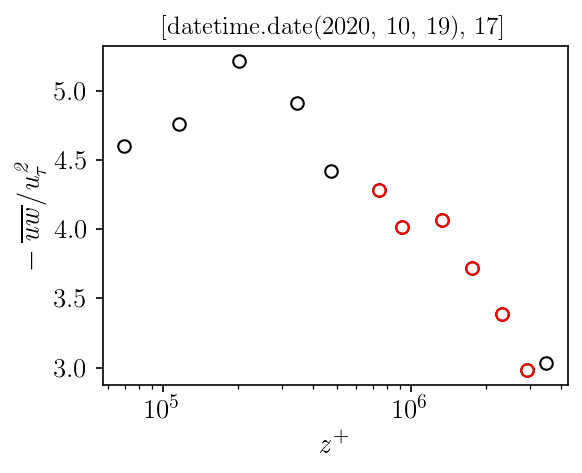

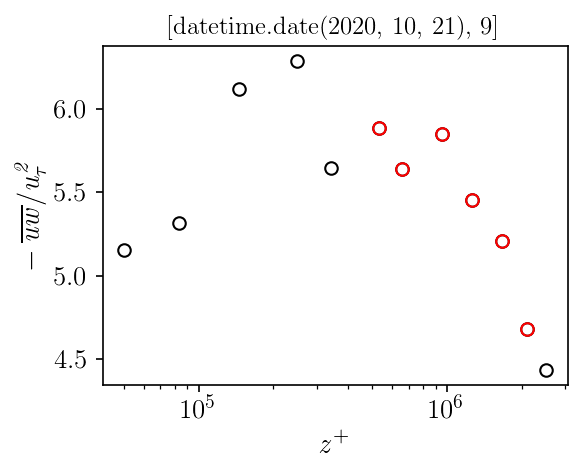

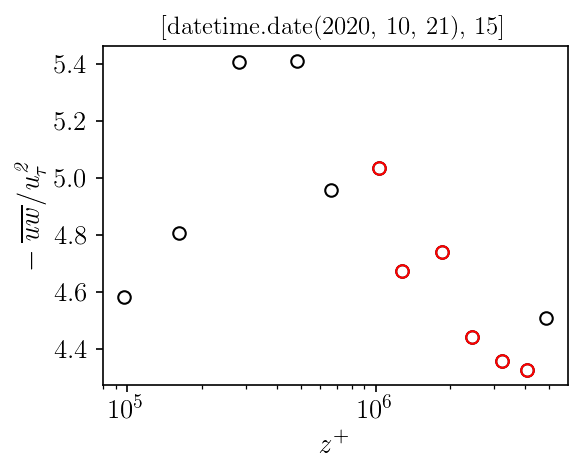

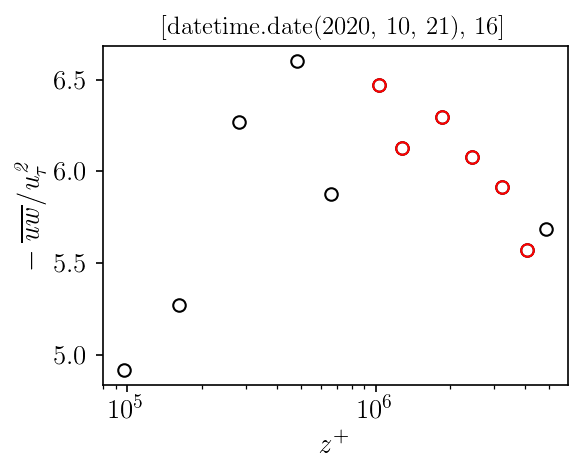

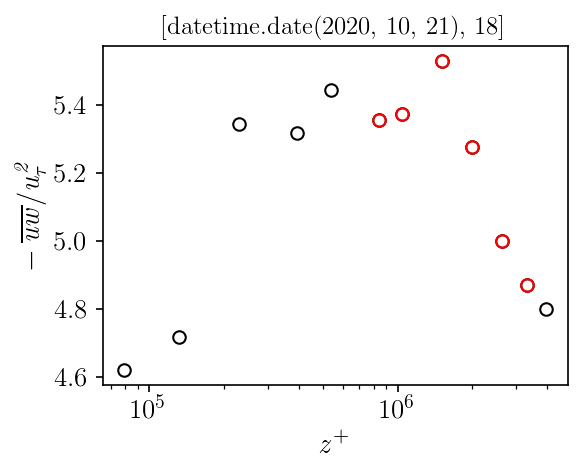

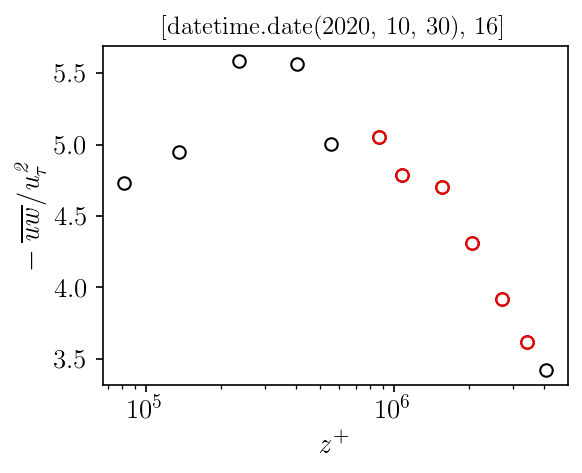

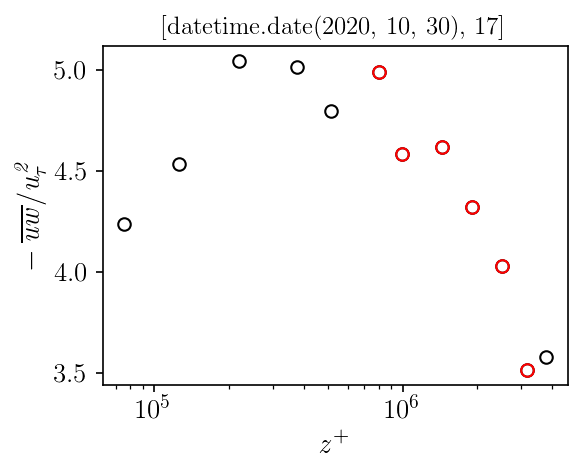

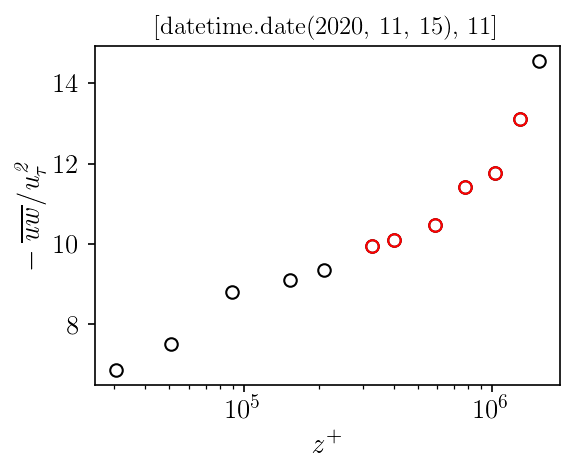

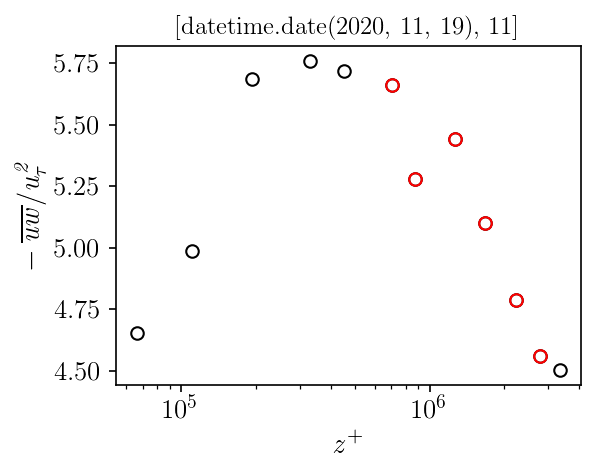

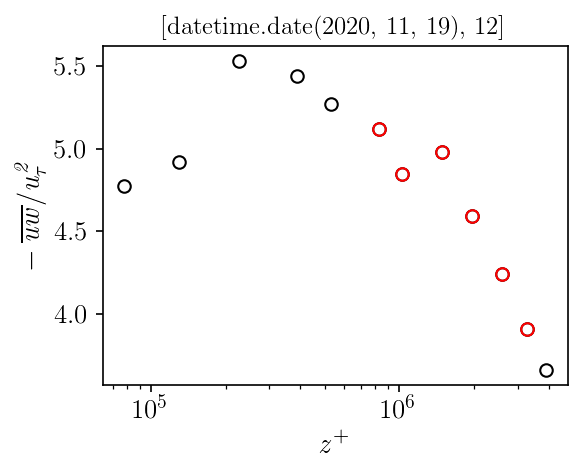

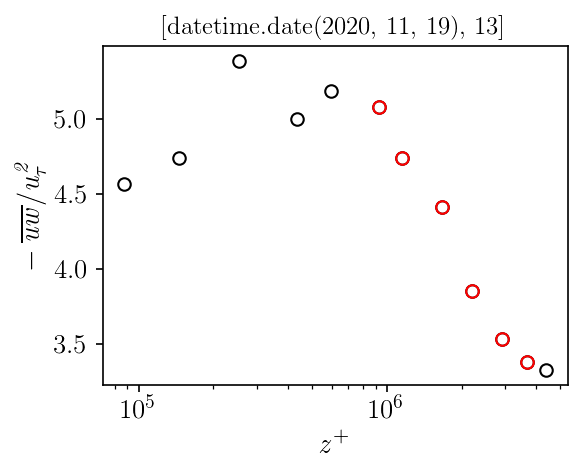

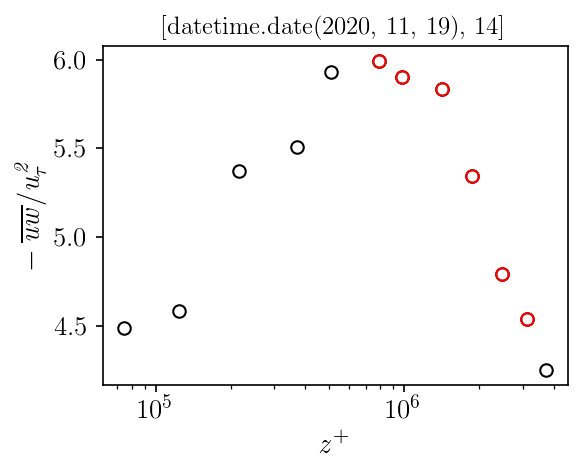

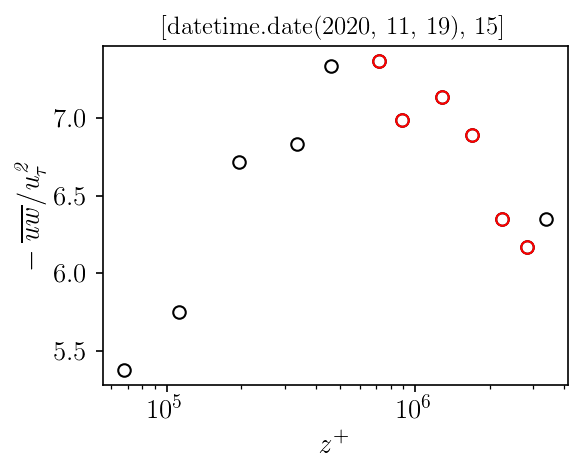

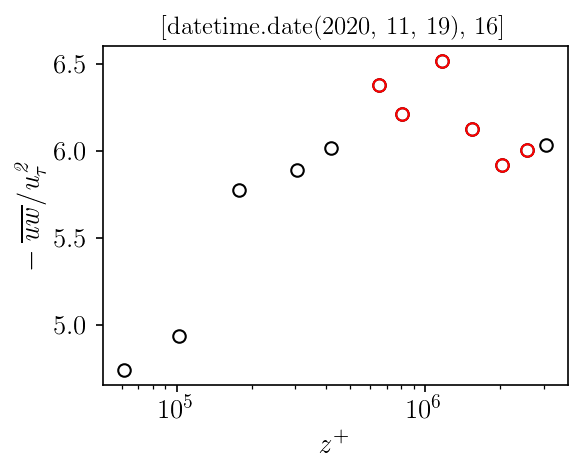

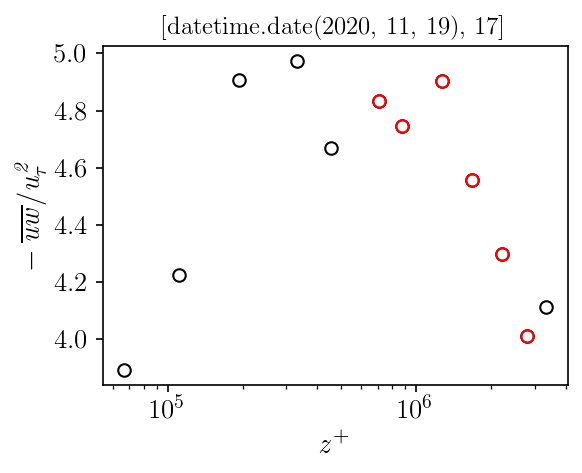

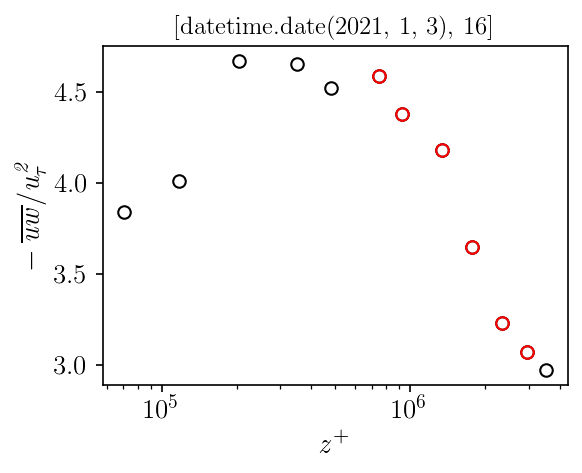

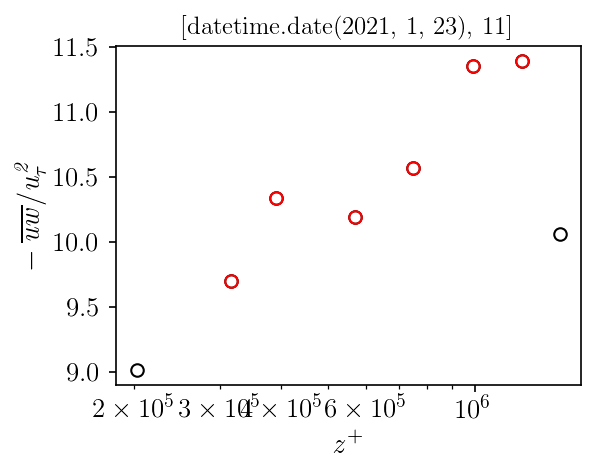

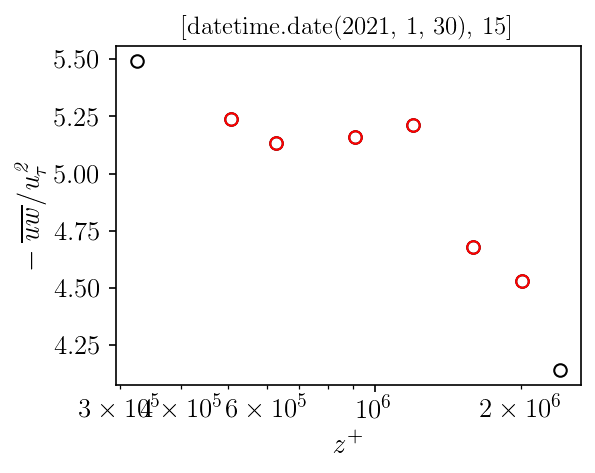

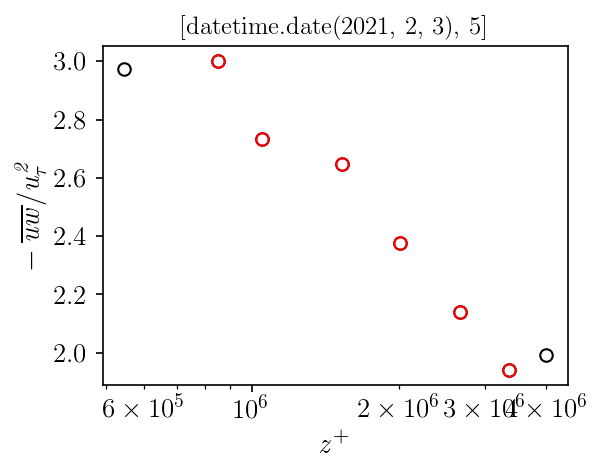

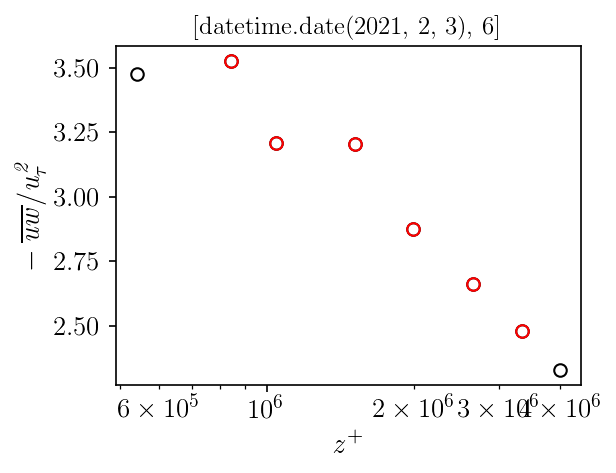

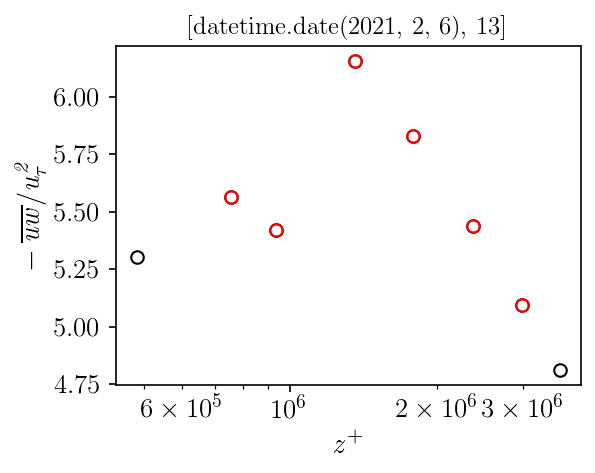

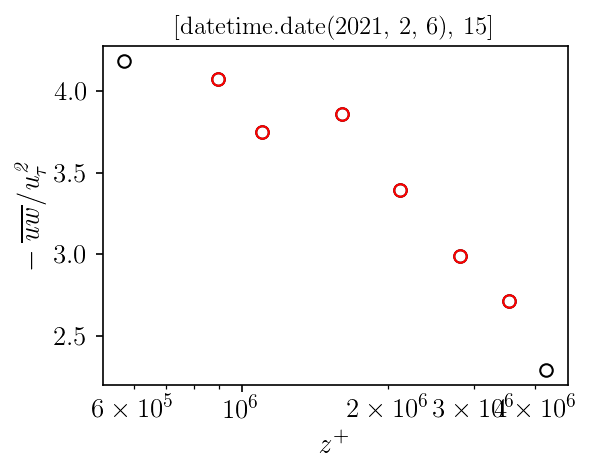

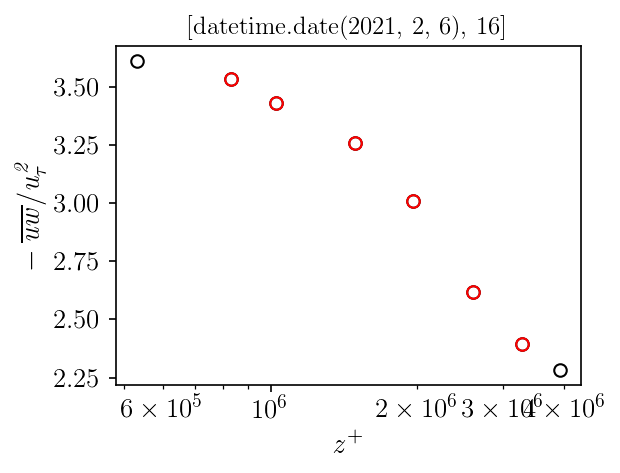

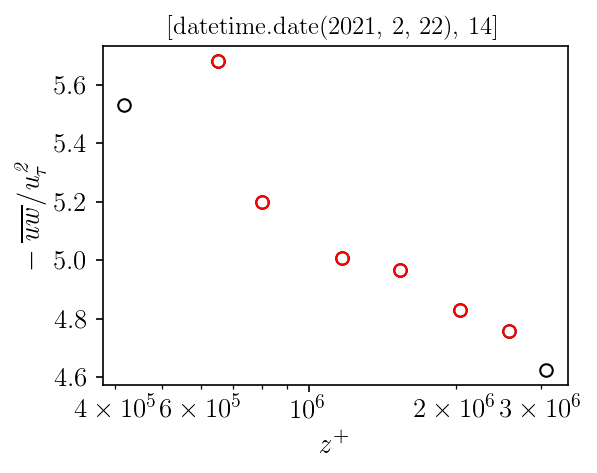

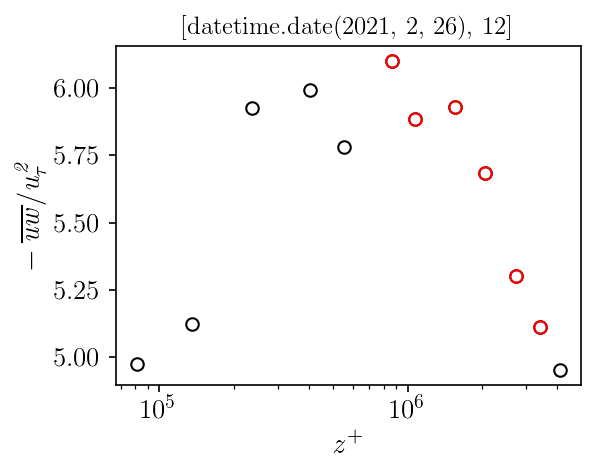

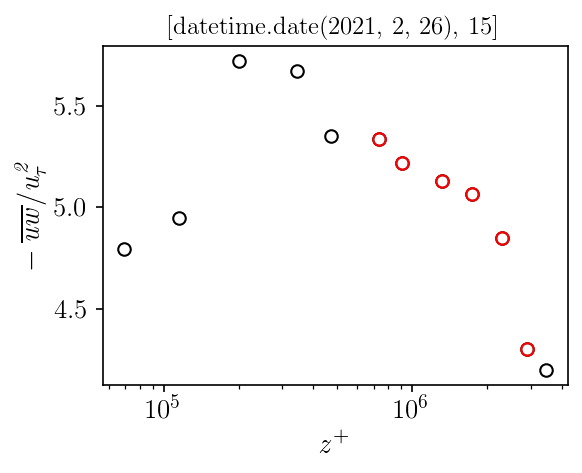

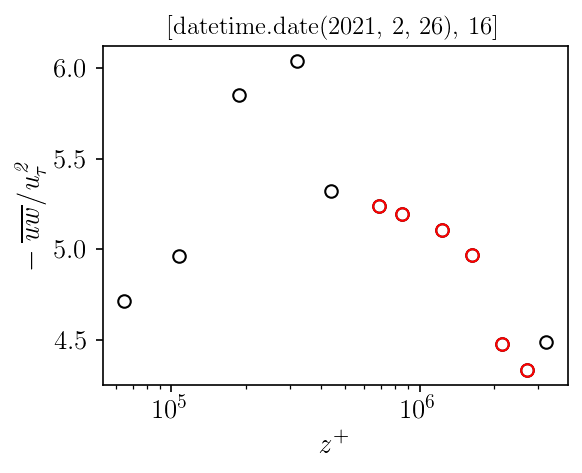

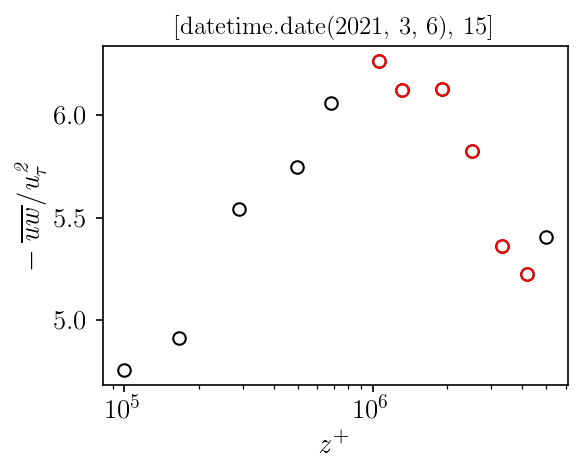

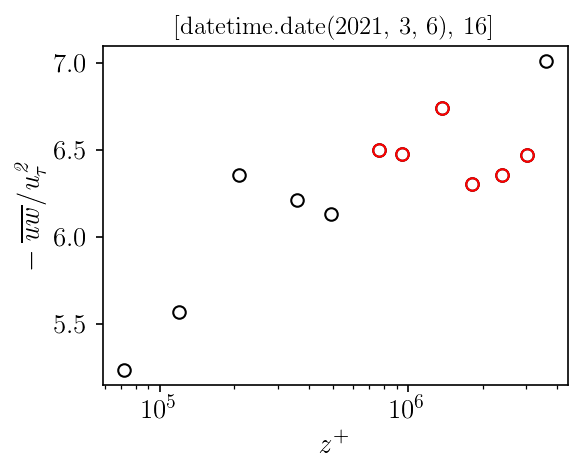

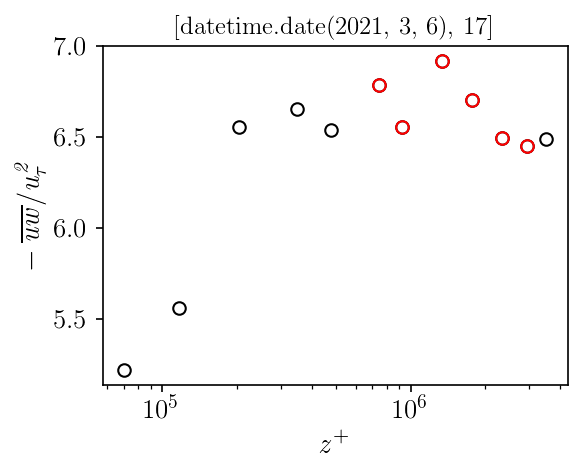

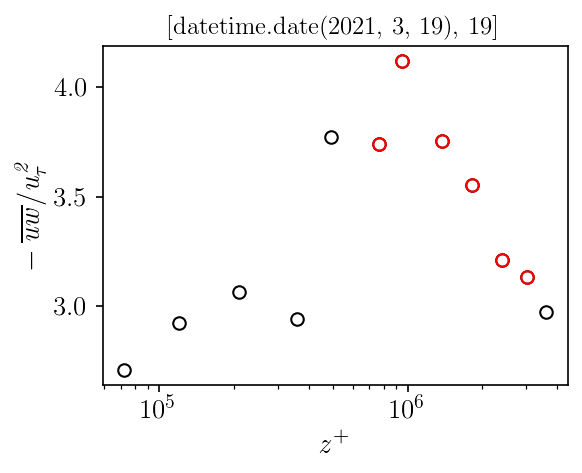

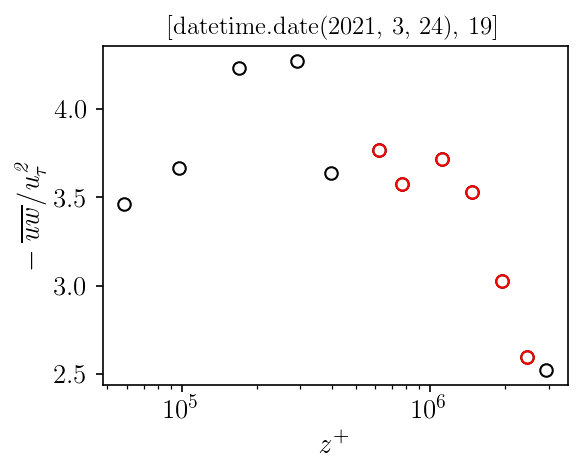

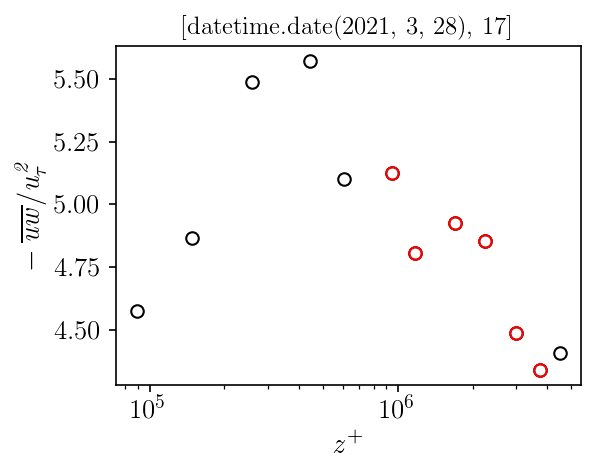

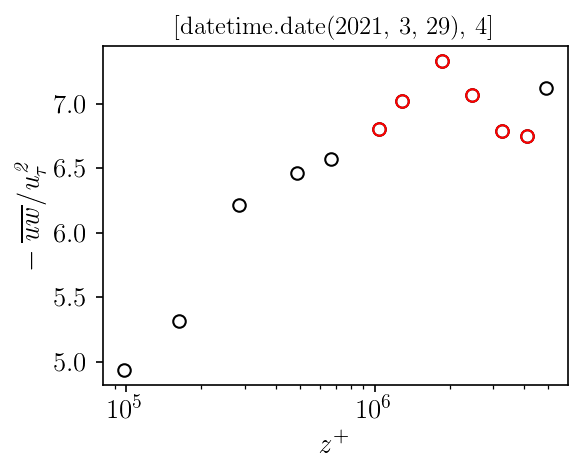

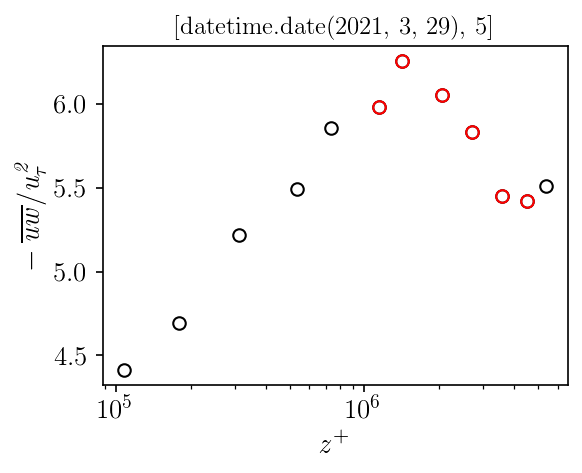

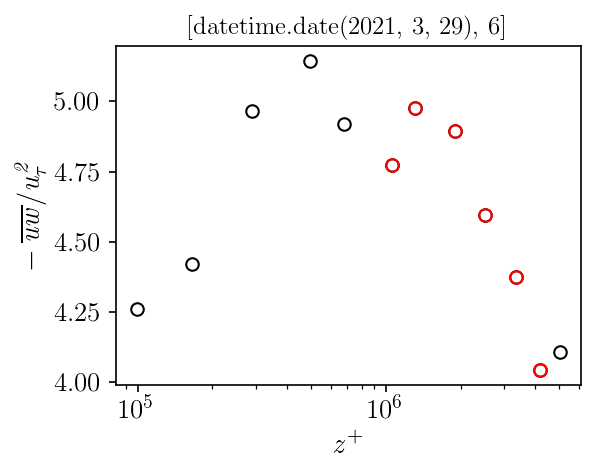

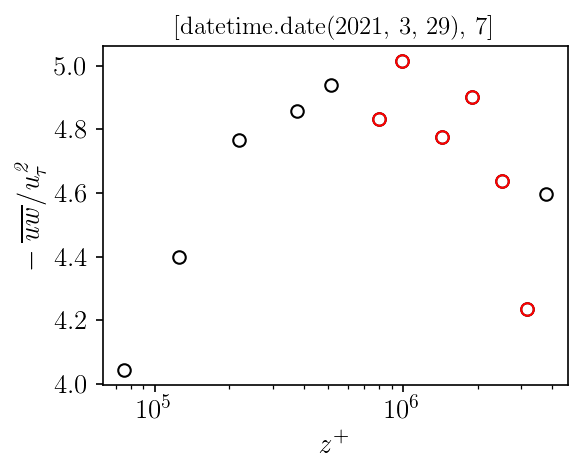

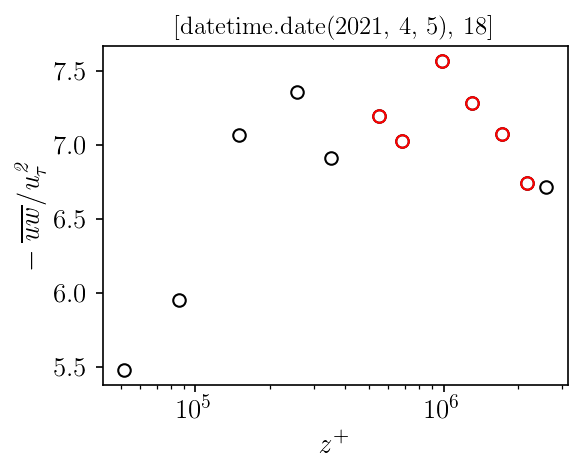

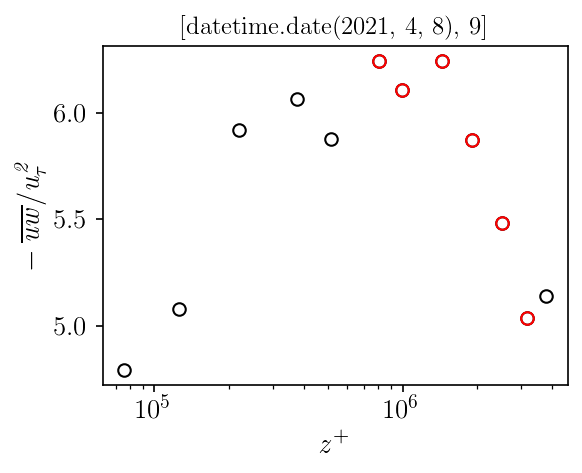

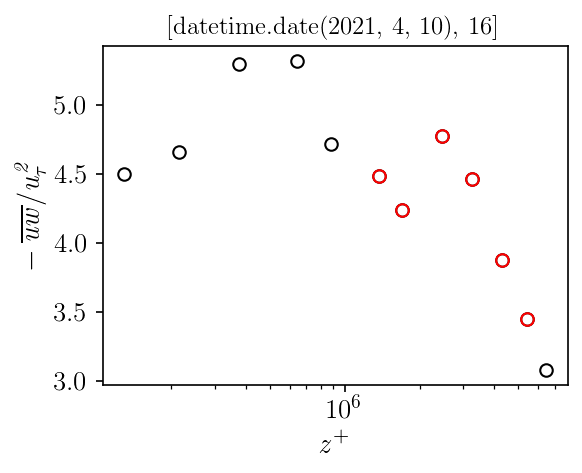

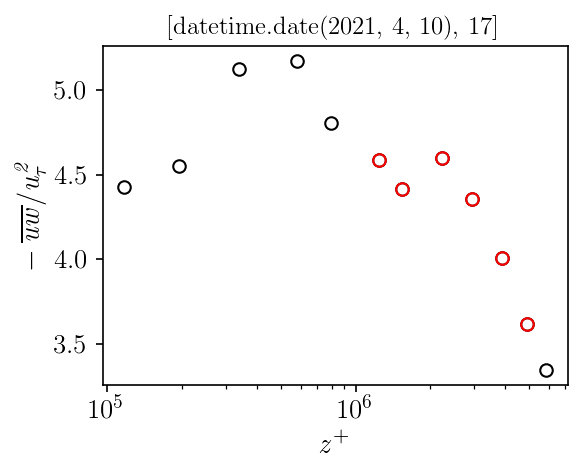

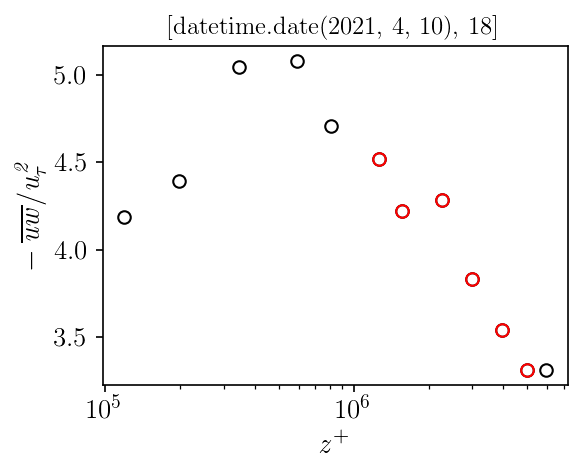

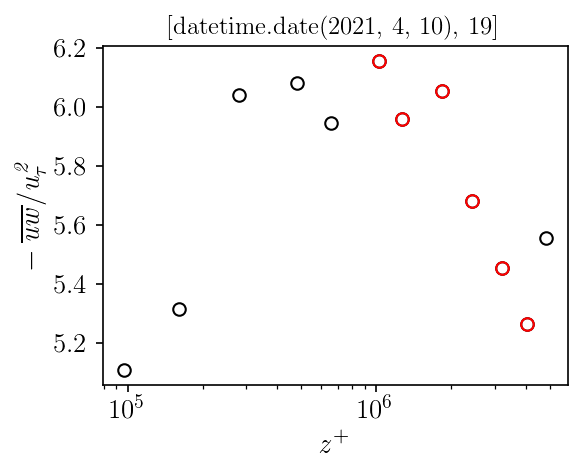

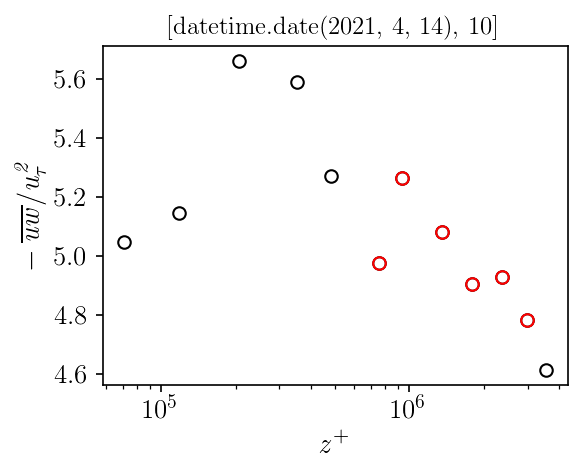

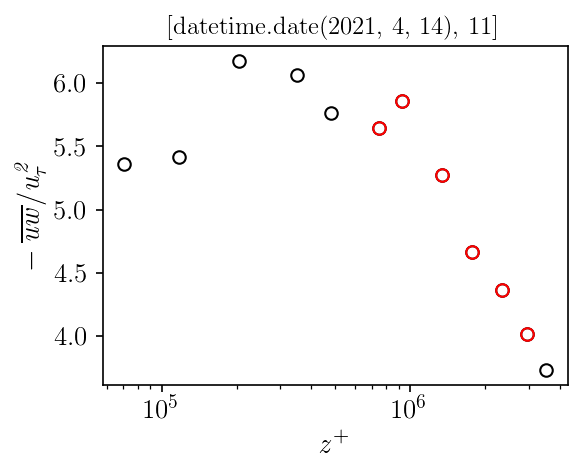

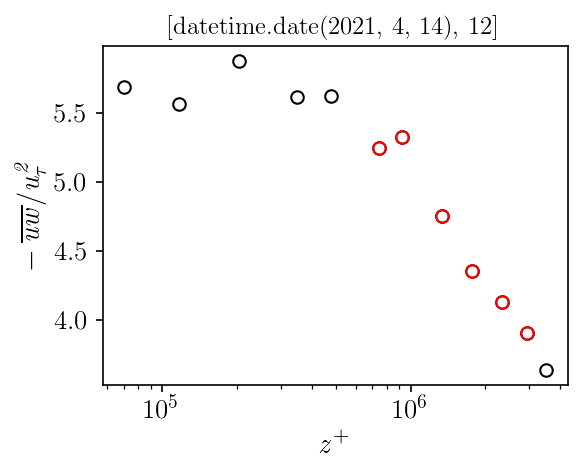

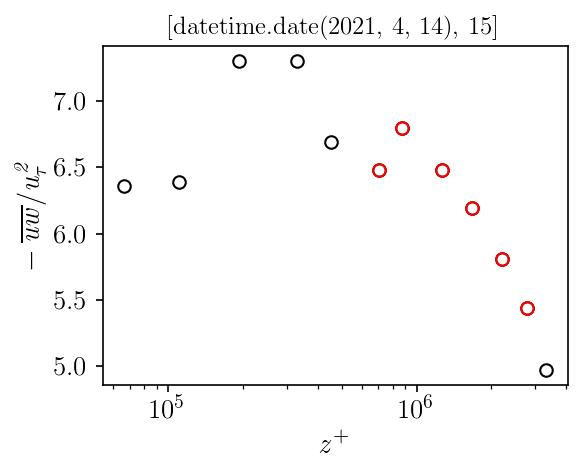

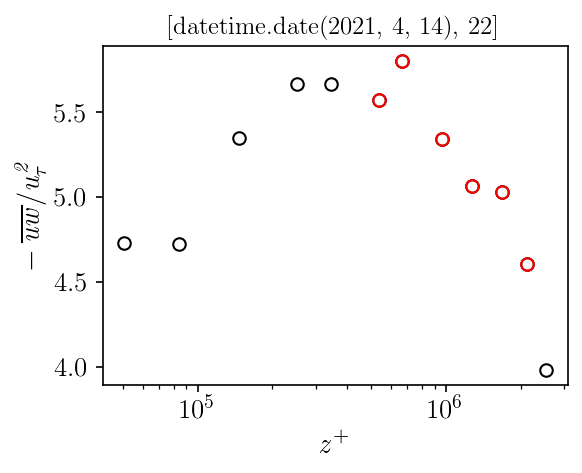

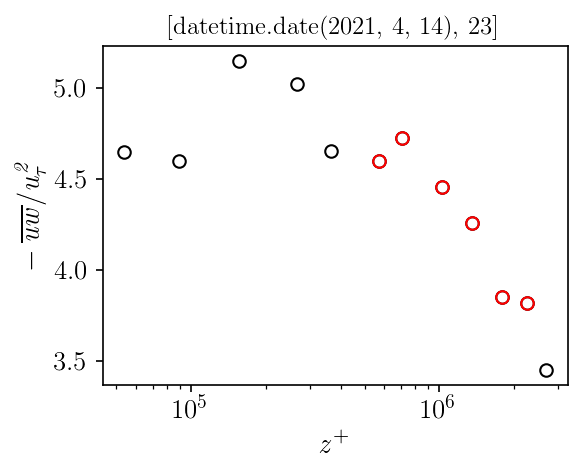

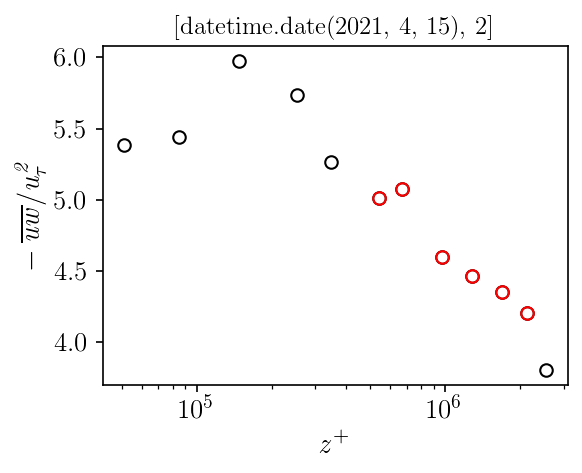

In [57]:
x_temp = z[None,:]*u_star_m1[:,None]/nu
y_temp = uw_neutral/(u_star_m1**2)[:,None]
N = np.arange(0,len(neutral_case))
msk = np.logical_and((abs(kappa_m2-0.4)/0.4)<1,ist<0.3)
for i in N[msk]:
    plt.figure(figsize=(4,3),dpi=150)
    plt.plot(x_temp[i,:],y_temp[i,:],'o',color = 'k',markerfacecolor='none')
    plt.plot(x_temp[i,list_sel_m2],y_temp[i,list_sel_m2],'o',color = 'red',markerfacecolor='none')
    plt.title(neutral_case[i], fontsize = 12)
    plt.xlabel(r'$\it z^+$', fontsize = font_size)
    plt.ylabel(r'$\it -\overline{uw}/u_{\tau}^2$', fontsize = font_size)
    ax = plt.gca()
    ax.set_xscale('log')
    # plt.ylim(0.86, 1)

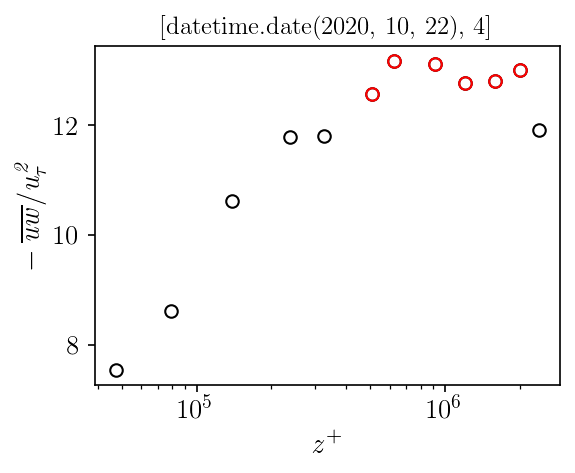

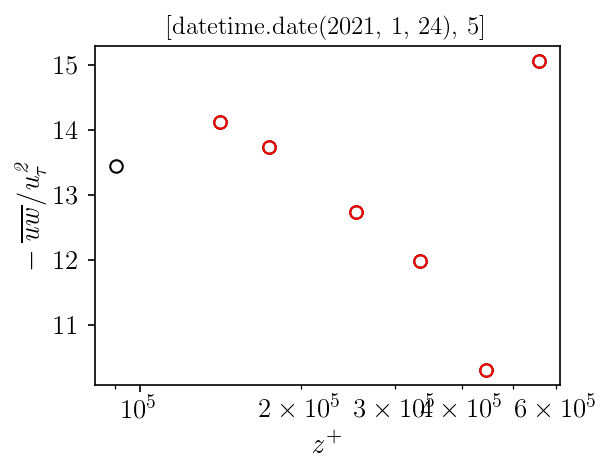

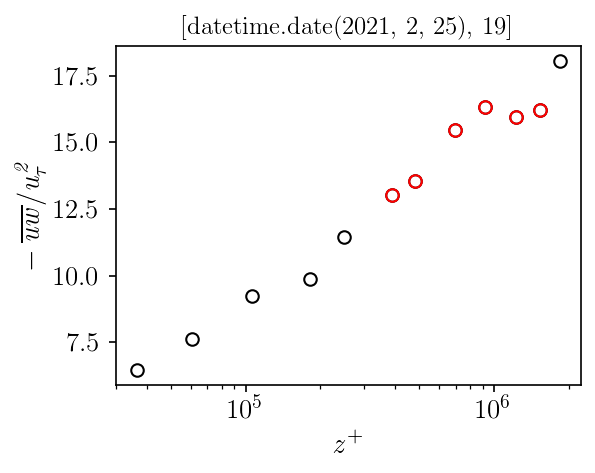

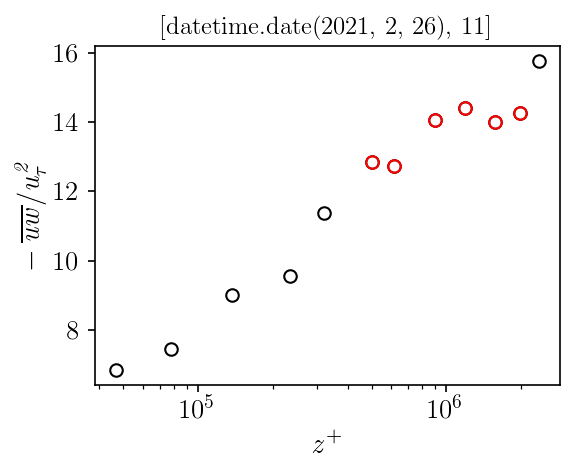

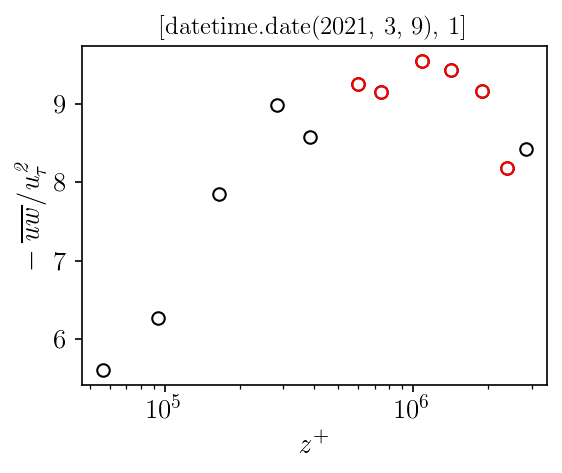

In [60]:
x_temp = z[None,:]*u_star_m1[:,None]/nu
y_temp = uw_neutral/(u_star_m1**2)[:,None]
N = np.arange(0,len(neutral_case))
msk = np.logical_and((abs(kappa_m2-0.4)/0.4)<1,ist>0.3)
for i in N[msk]:
    plt.figure(figsize=(4,3),dpi=150)
    plt.plot(x_temp[i,:],y_temp[i,:],'o',color = 'k',markerfacecolor='none')
    plt.plot(x_temp[i,list_sel_m2],y_temp[i,list_sel_m2],'o',color = 'red',markerfacecolor='none')
    plt.title(neutral_case[i], fontsize = 12)
    plt.xlabel(r'$\it z^+$', fontsize = font_size)
    plt.ylabel(r'$\it -\overline{uw}/u_{\tau}^2$', fontsize = font_size)
    ax = plt.gca()
    ax.set_xscale('log')

## neutral case variance ##

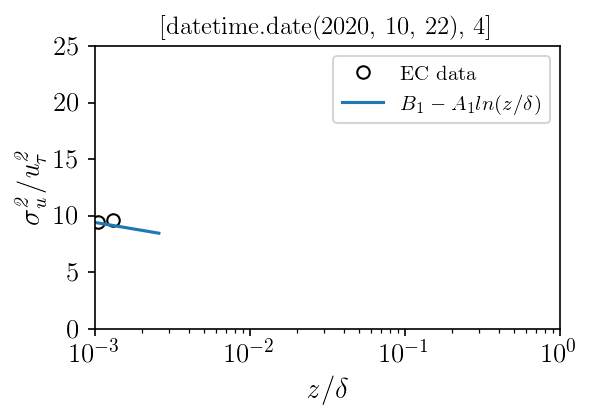

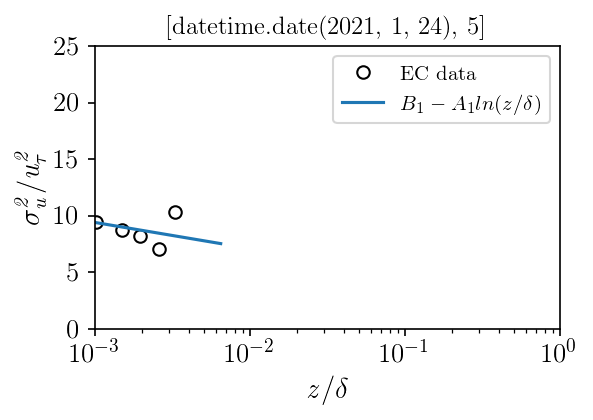

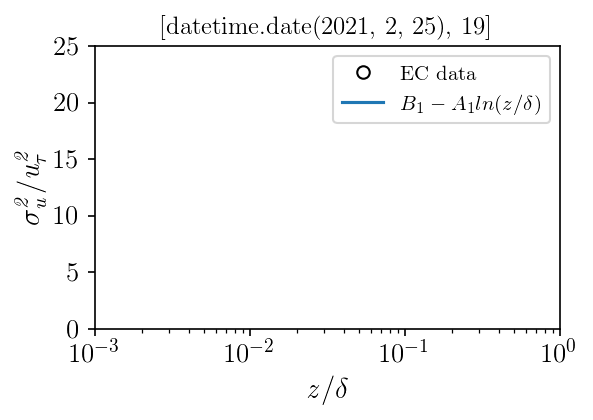

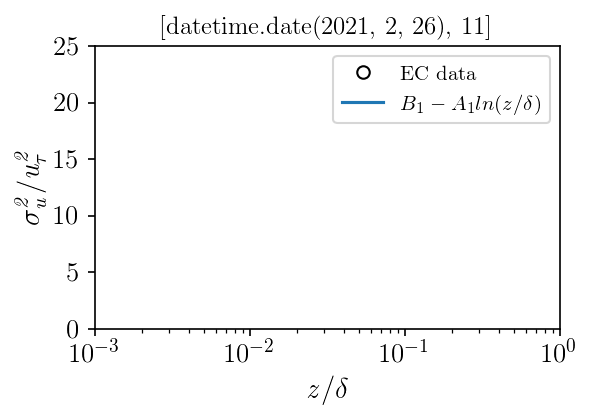

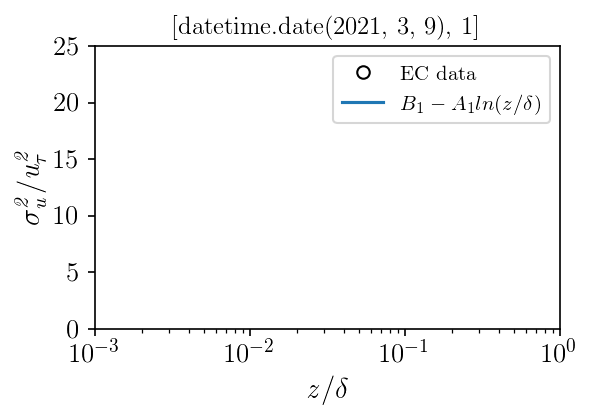

In [61]:
u_std_plus = (u_std_neutral**2)/(u_star_fit**2)[:,None]
# nn = len(neutral_case)
N = np.arange(0,len(neutral_case))
for i in N[msk]:
    plt.figure(figsize=(4, 2.5), dpi=150)
    plt.plot(z[list_sel_m2]/delta0[i],u_std_plus[i,list_sel_m1],'o',color = 'k',markerfacecolor='none')
    y1_test=np.logspace(-4,2,100)
    plt.plot(y1_test/delta0[i],B1-A1*np.log(y1_test/delta0[i]))
    plt.title(neutral_case[i], fontsize = 12)
    plt.xlabel(r'$\it z/\delta$', fontsize = font_size)
    plt.ylabel(r'$\it \sigma_u^2/u_{\tau}^2$', fontsize = font_size)
    plt.xlim(1e-3, 1)
    plt.ylim(0, 25)
    ax = plt.gca()
    ax.set_xscale('log')
    ax.legend(['EC data','$B_1-A_1ln(z/\delta)$'])
# plt.savefig(OUT_DIRECTORY + 'neutral_hour_hist.png', dpi=200)